### Load libraries

In [1]:
library(CellChat)
library(Seurat)
library(patchwork)
options(stringsAsFactors = FALSE)

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: igraph

Warning message:
"package 'igraph' was built under R version 4.4.1"

Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union


Loading required package: ggplot2

Loading required package: SeuratObject

Loading required package: sp

'SeuratObject' was built with package 'Matrix' 1.7.0 but the current
version is 1.7.1; it is recomended that you reinstall 'SeuratObject' as
the ABI for 'Matrix' may have changed


Attaching package: 'SeuratObject'


The following object is masked from 'package:BiocGenerics':

    intersec

### Load `Seurat` object

In [23]:
seurat_object <- readRDS("../Clustering/out/clustered_harmony_HGG.rds")

In [121]:
seurat_object@meta.data$RNA_snn_res.0.9 <- paste0(
  "C",
  seurat_object@meta.data$RNA_snn_res.0.9
)
Idents(seurat_object) <- "RNA_snn_res.0.9"
DefaultAssay(seurat_object) <- "RNA"

In [123]:
seurat_object$ident <- seurat_object@meta.data$RNA_snn_res.0.9

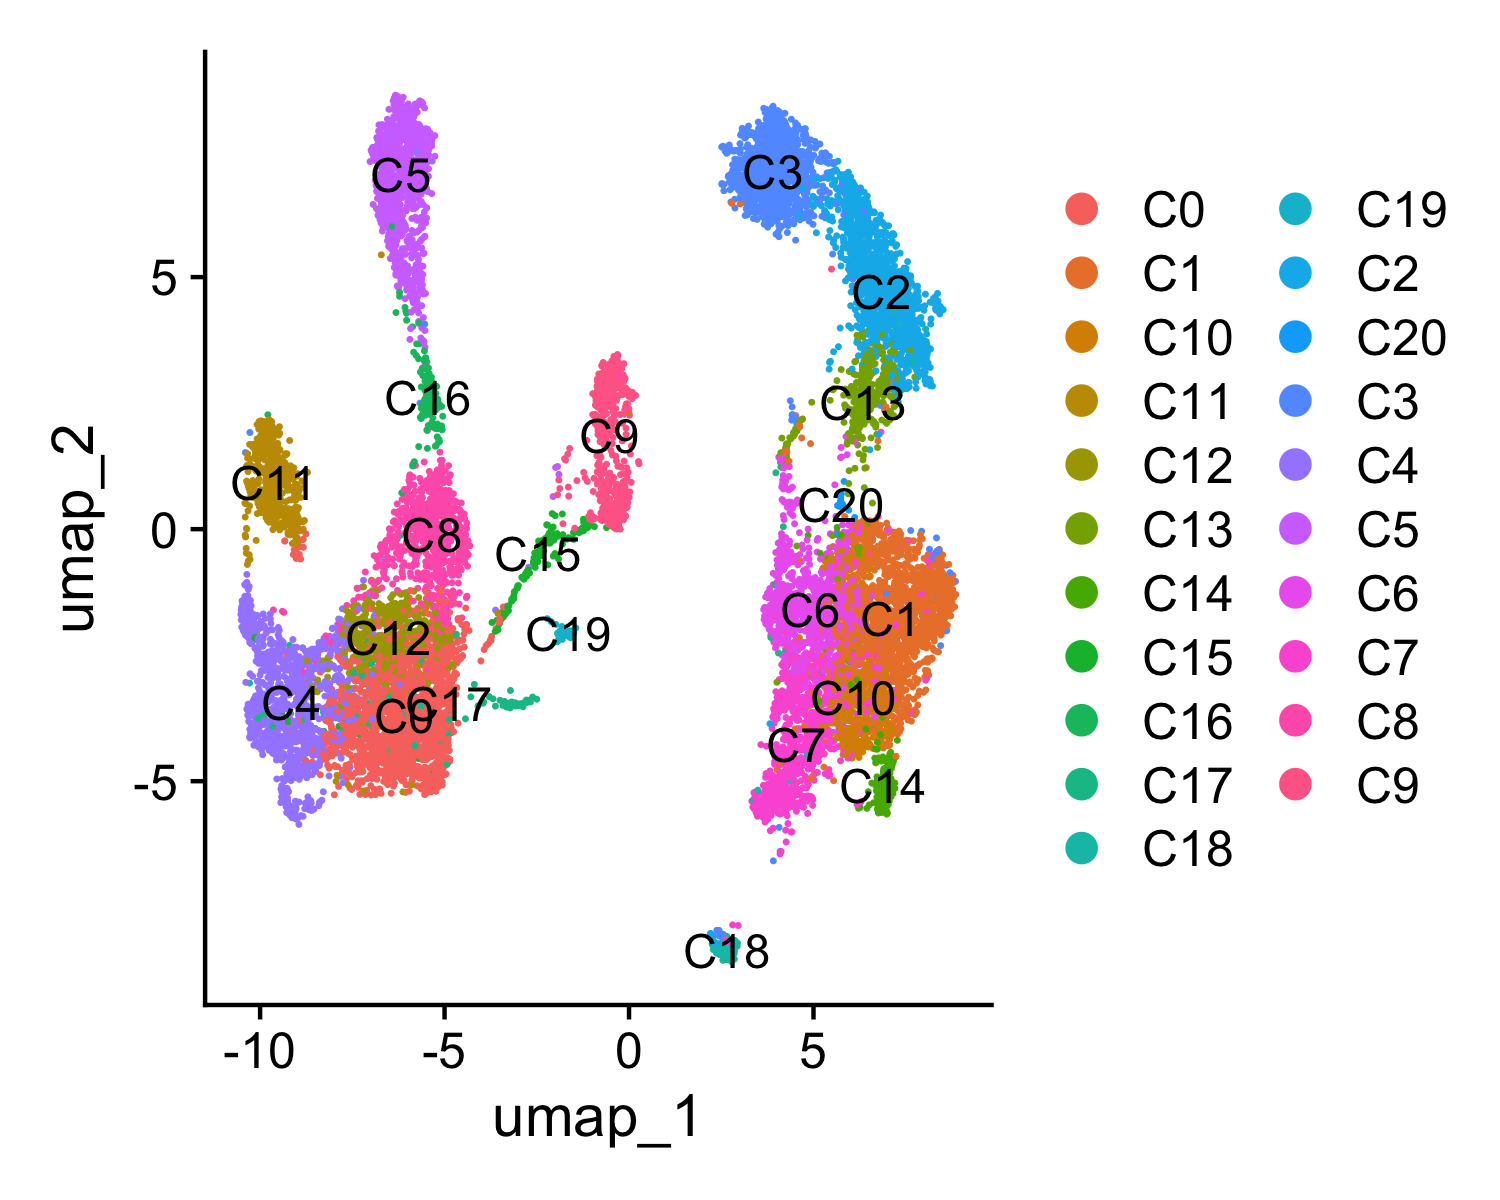

In [125]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 300)
DimPlot(seurat_object, label = TRUE)

### Create `CellChat` object

In [126]:
cellchat <- createCellChat(
  object = seurat_object,
  group.by = "ident",
  meta = seurat_object@meta.data,
  assay = "RNA"
)

[1] "Create a CellChat object from a Seurat object"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  C0 C1 C10 C11 C12 C13 C14 C15 C16 C17 C18 C19 C2 C20 C3 C4 C5 C6 C7 C8 C9 


In [127]:
cellchat <- addMeta(cellchat, meta = seurat_object@meta.data)
cellchat <- setIdent(cellchat, ident.use = "ident") 
levels(cellchat@idents) 
groupSize <- as.numeric(table(cellchat@idents)) 

[1] "C0"  "C1"  "C10" "C11" "C12" "C13" "C14" "C15" "C16" "C17" "C18" "C19"
[13] "C2"  "C20" "C3"  "C4"  "C5"  "C6"  "C7"  "C8"  "C9"

### Set the ligand-receptor interaction database

In [128]:
cellchat

An object of class CellChat created from a single dataset 
 40284 genes.
 13988 cells. 
CellChat analysis of single cell RNA-seq data! 

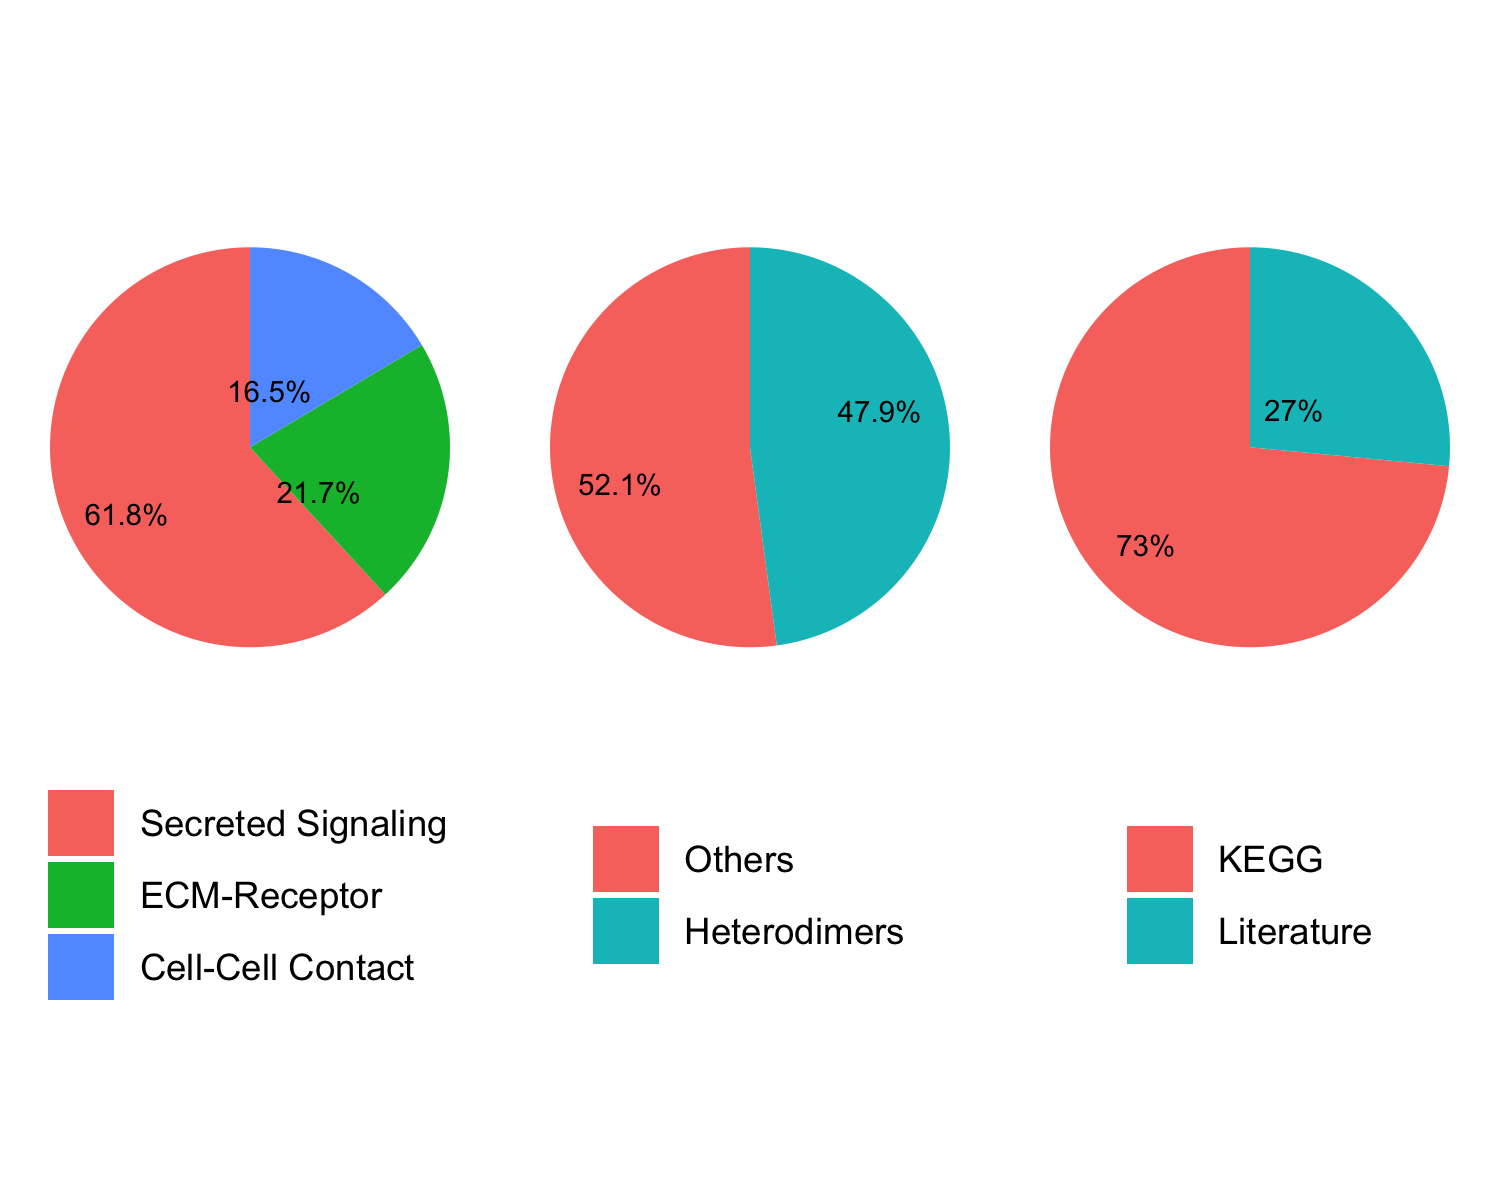

In [129]:
CellChatDB <- CellChatDB.human
showDatabaseCategory(CellChatDB)

In [130]:
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling")

In [131]:
cellchat@DB <- CellChatDB.use

In [132]:
cellchat <- subsetData(cellchat)

### Preprocessing the expression data for cell-cell communication analysis

In [133]:
future::plan("multisession", workers = 10)

In [134]:
options(future.globals.maxSize = 8000 * 1024^2)

In [135]:

cellchat <- identifyOverExpressedGenes(cellchat)


In [136]:
cellchat <- identifyOverExpressedInteractions(cellchat)

### Compute the communication probability and infer cellular communication network

In [137]:
cellchat <- computeCommunProb(cellchat, type = "triMean")

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-12-25 16:28:26.658847]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-12-25 16:33:23.850535]"


In [138]:
cellchat <- filterCommunication(cellchat, min.cells = 10)

### Extract the inferred cellular communication network as a data frame

In [139]:
cellchat <- computeCommunProbPathway(cellchat)

### Calculate the aggregated cell-cell communication network

In [140]:
cellchat <- aggregateNet(cellchat)

### Save `CellChat` object

In [141]:
saveRDS(file = "out/cellchat_p1.rds", cellchat)

In [73]:
tempdir()

[1] "/var/folders/xp/m16lgcdj3c3_c4y7xpgrt_n80000gn/T//RtmpiCqNIt"

### Visualize

In [ ]:
library(svglite)

groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1, 2), xpd = TRUE)
netVisual_circle(
  cellchat@net$count,
  vertex.weight = groupSize,
  weight.scale = TRUE,
  label.edge = FALSE,
  title.name = "Number of interactions"
)
netVisual_circle(
  cellchat@net$weight,
  vertex.weight = groupSize,
  weight.scale = TRUE,
  label.edge = FALSE,
  title.name = "Interaction weights/strength"
)


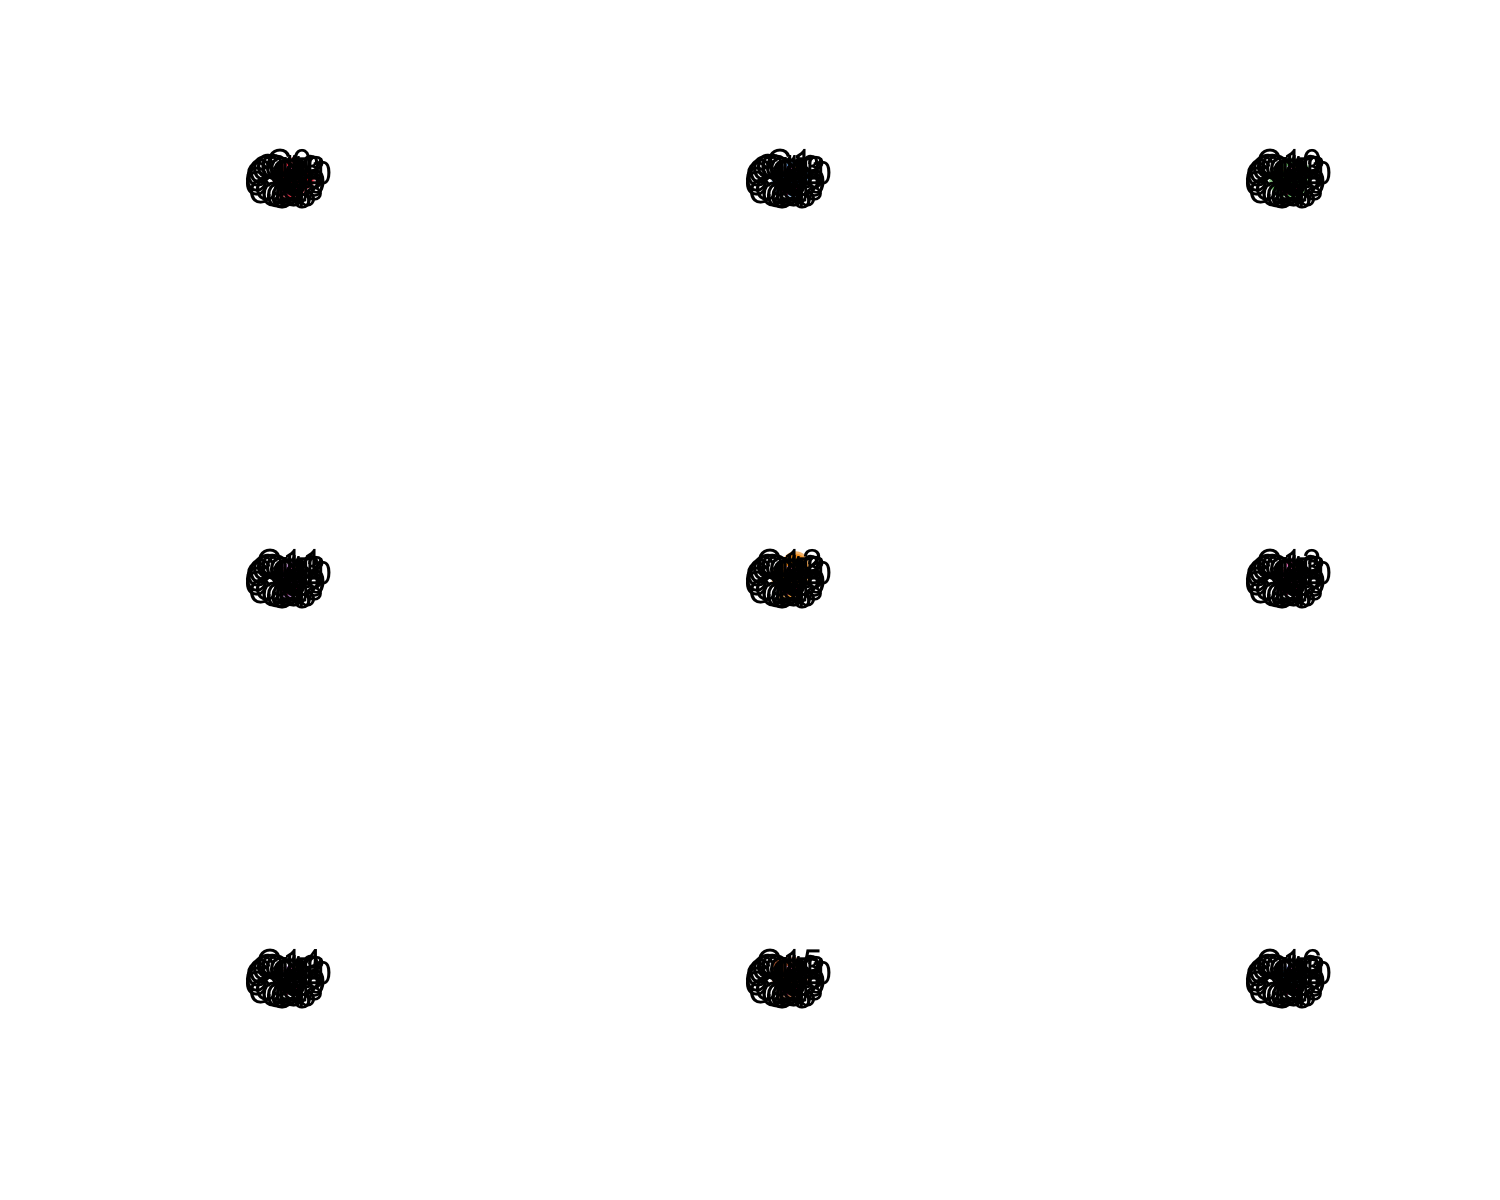

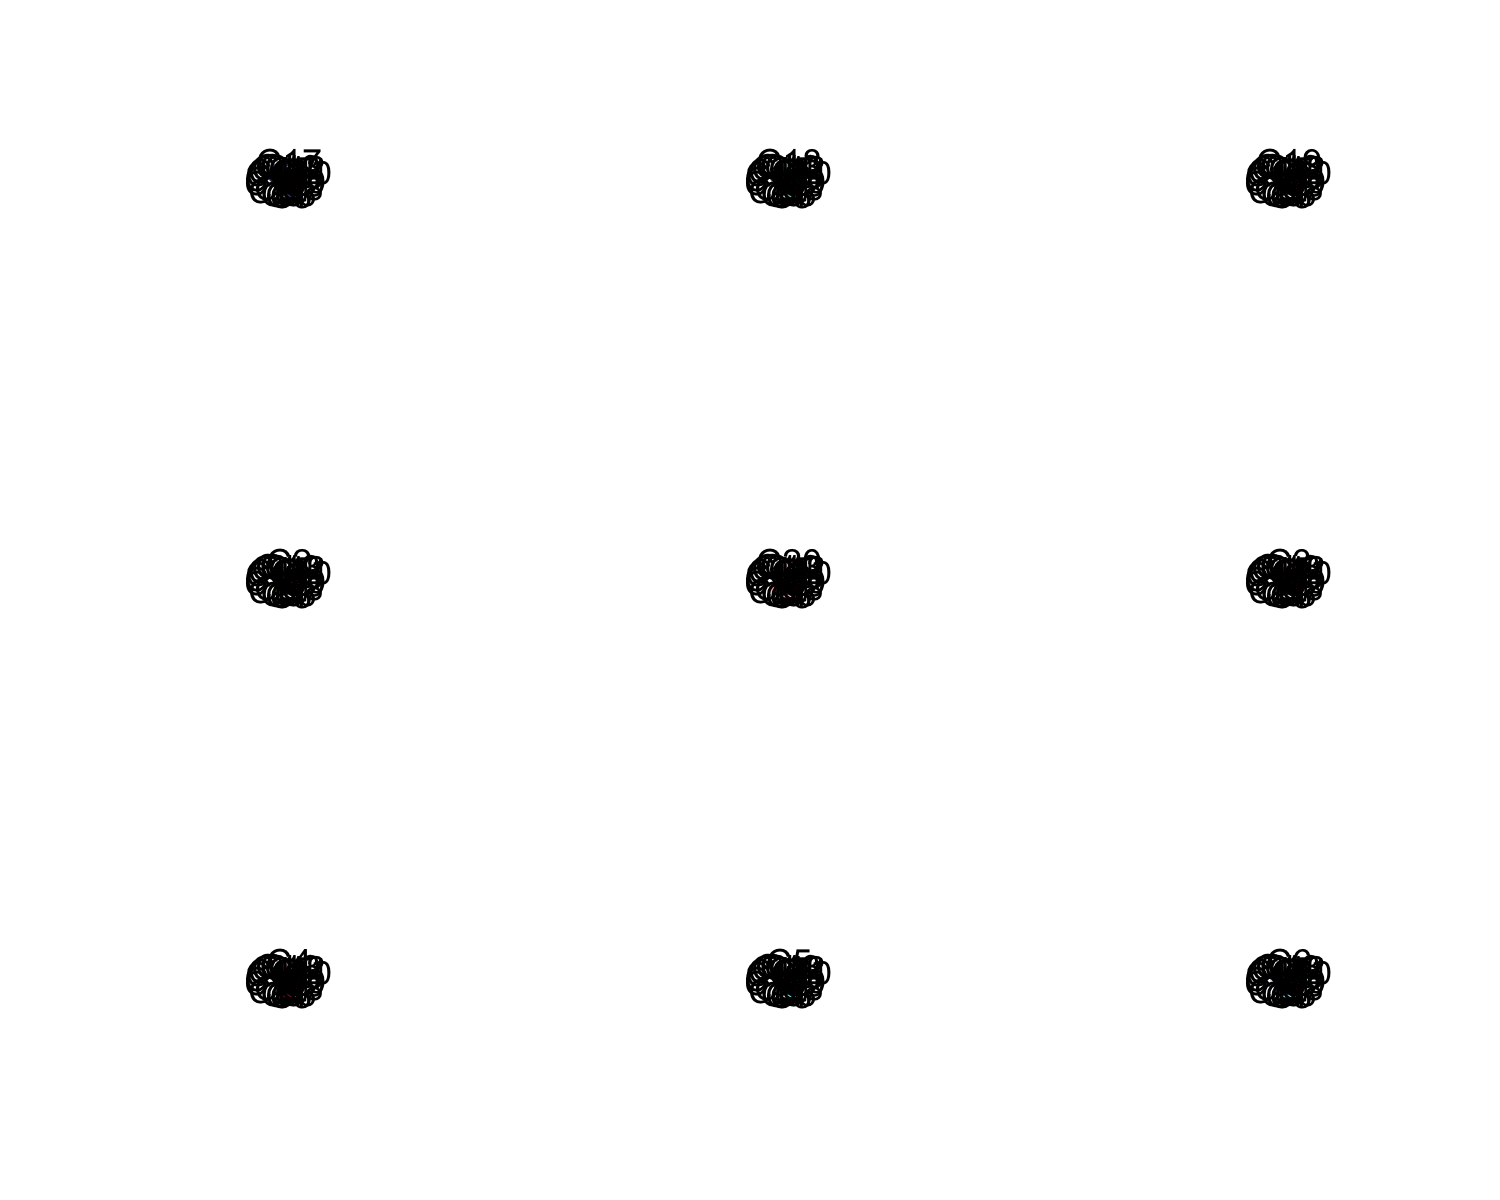

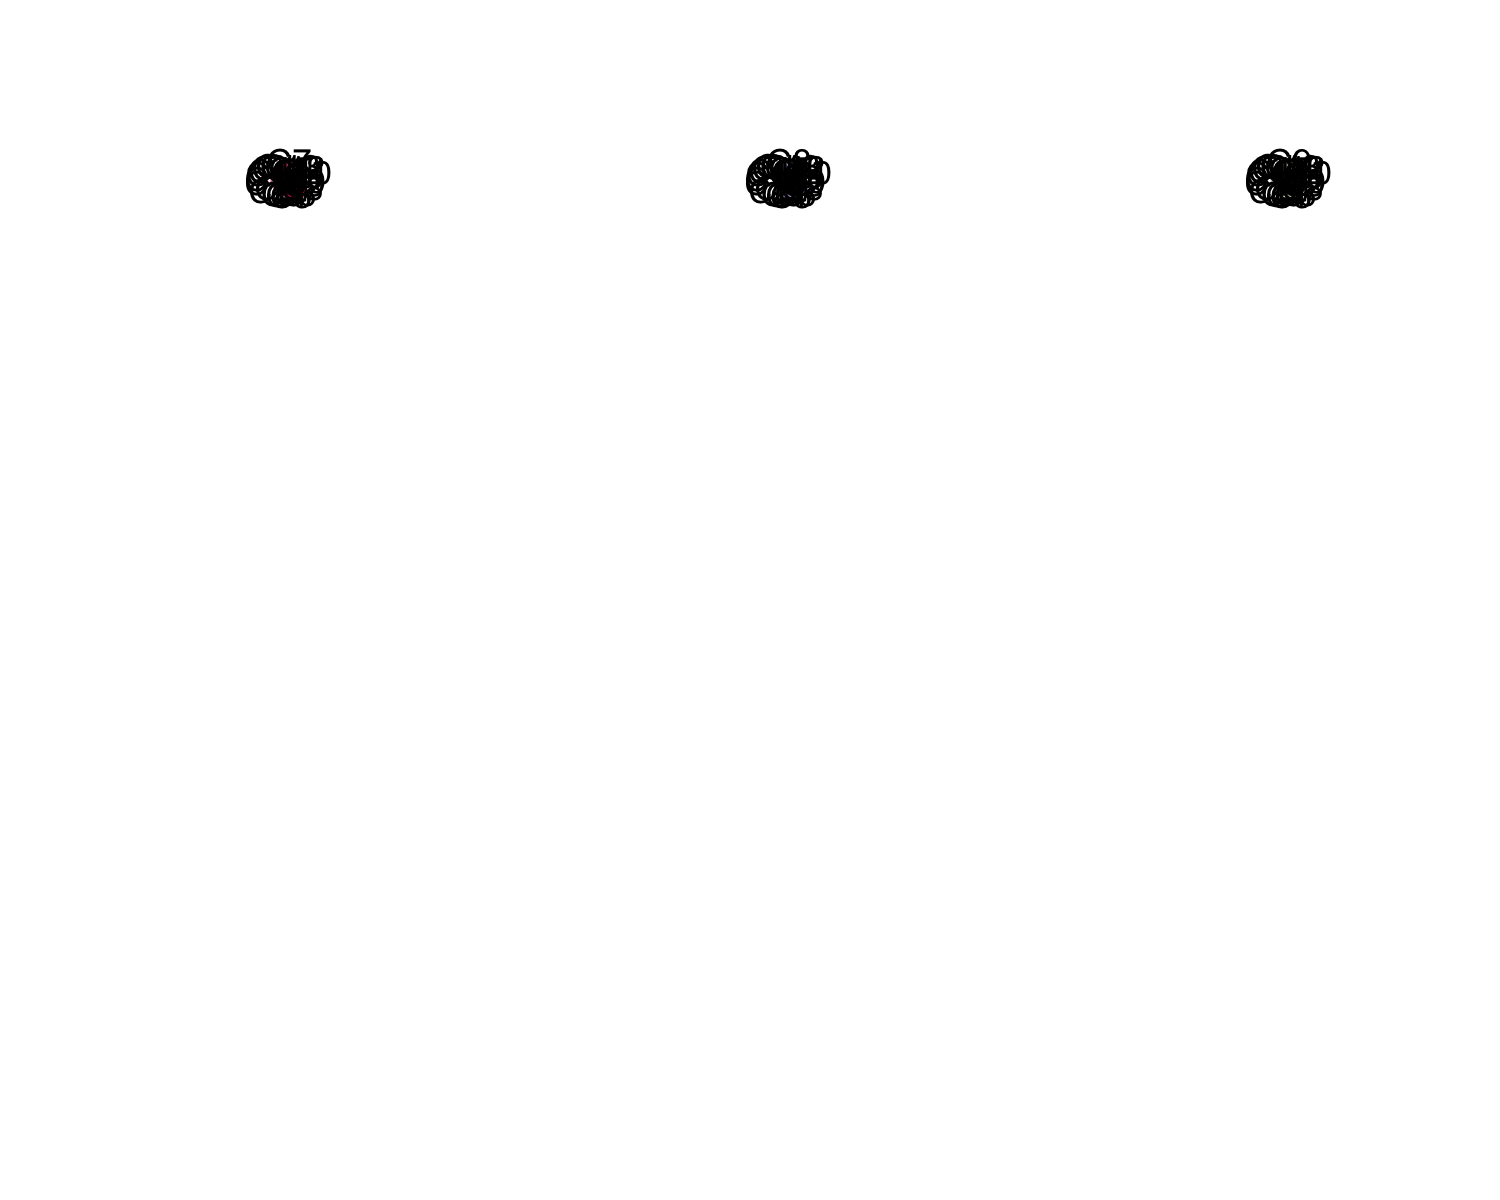

In [142]:
mat <- cellchat@net$weight
par(mfrow = c(3, 3), xpd=TRUE)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}

## Systems analysis of cell-cell communication network

### Identify signaling roles (e.g., dominant senders, receivers) of cell groups as well as the major contributing signaling

In [143]:
cellchat@netP$pathways

[1] "PTN"        "SPP1"       "MK"         "MIF"        "COMPLEMENT"
 [6] "GALECTIN"   "PSAP"       "CCL"        "ANNEXIN"    "GRN"       
[11] "VISFATIN"   "TGFb"       "PDGF"       "GAS"        "OSM"       
[16] "TNF"        "EGF"        "IGF"        "ANGPTL"     "IL16"      
[21] "TWEAK"      "ncWNT"      "VEGF"       "PARs"       "BMP"       
[26] "SEMA3"      "WNT"        "CALCR"      "ANGPT"      "FGF"       
[31] "CHEMERIN"

### Compute and visualize the network centrality scores

In [144]:
# the slot 'netP' means the inferred intercellular communication network of signaling pathways
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP")

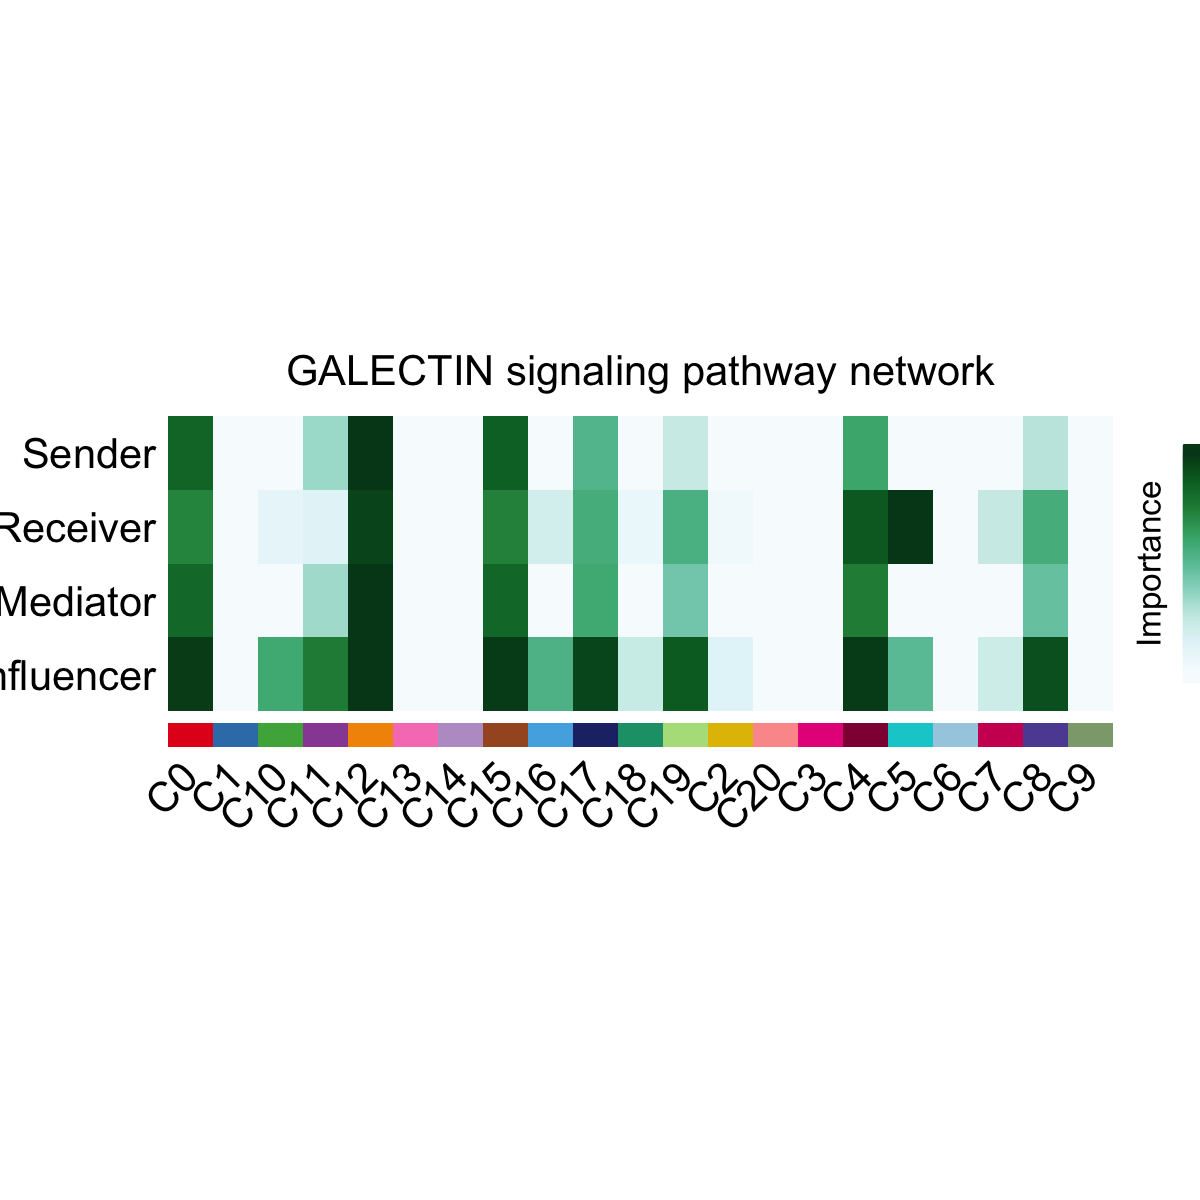

In [145]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)
netAnalysis_signalingRole_network(
  cellchat,
  signaling = c("GALECTIN"),
  width = 8,
  height = 2.5,
  font.size = 10
)

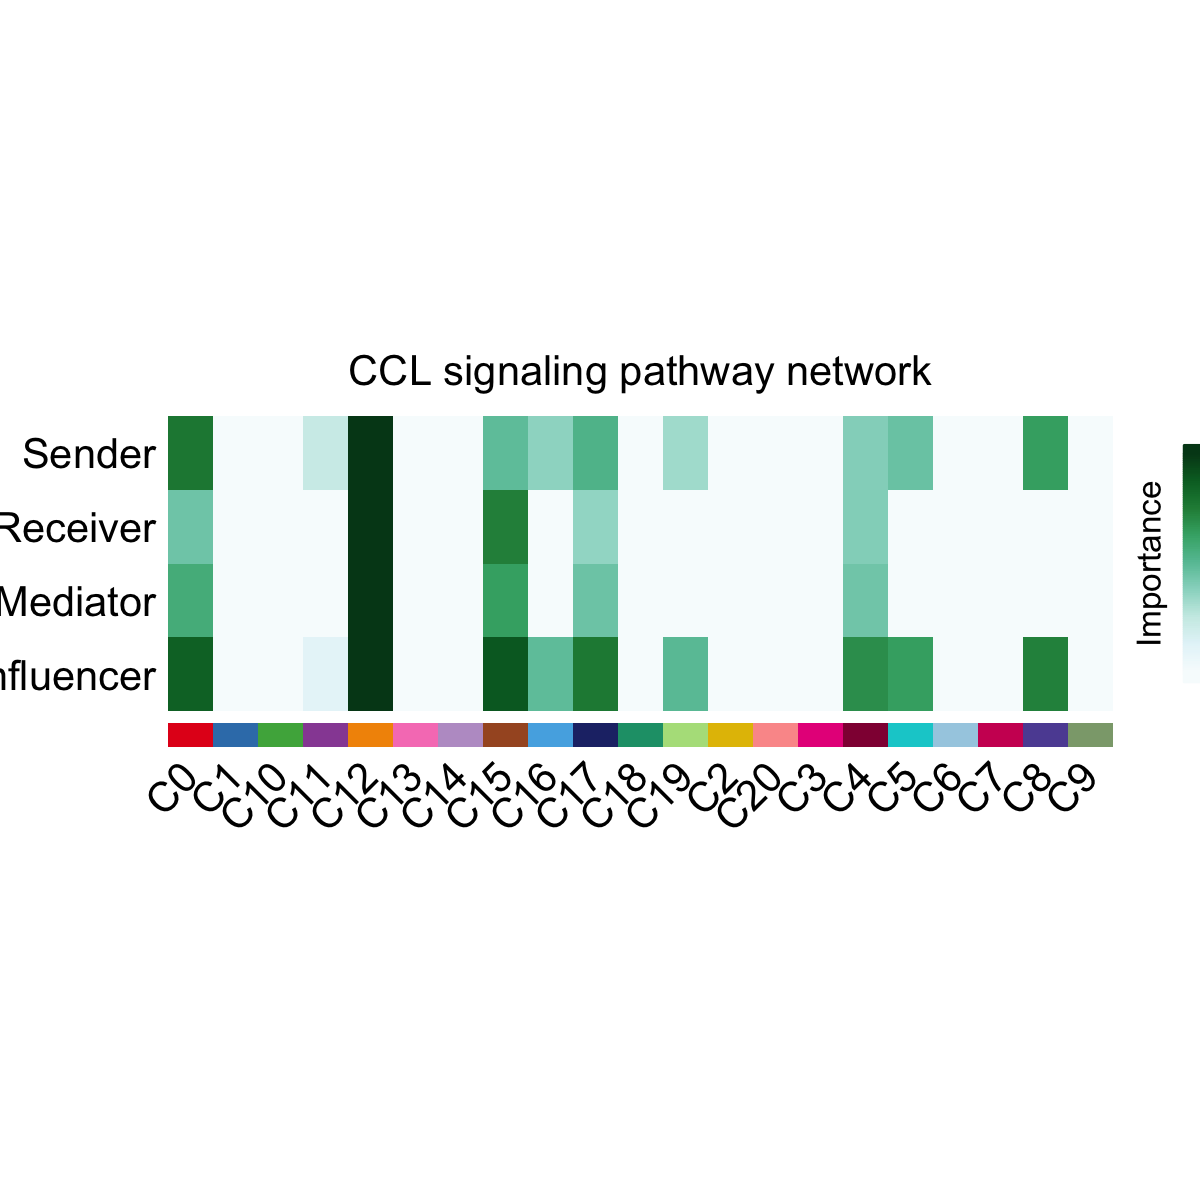

In [146]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)
netAnalysis_signalingRole_network(
  cellchat,
  signaling = c("CCL"),
  width = 8,
  height = 2.5,
  font.size = 10
)

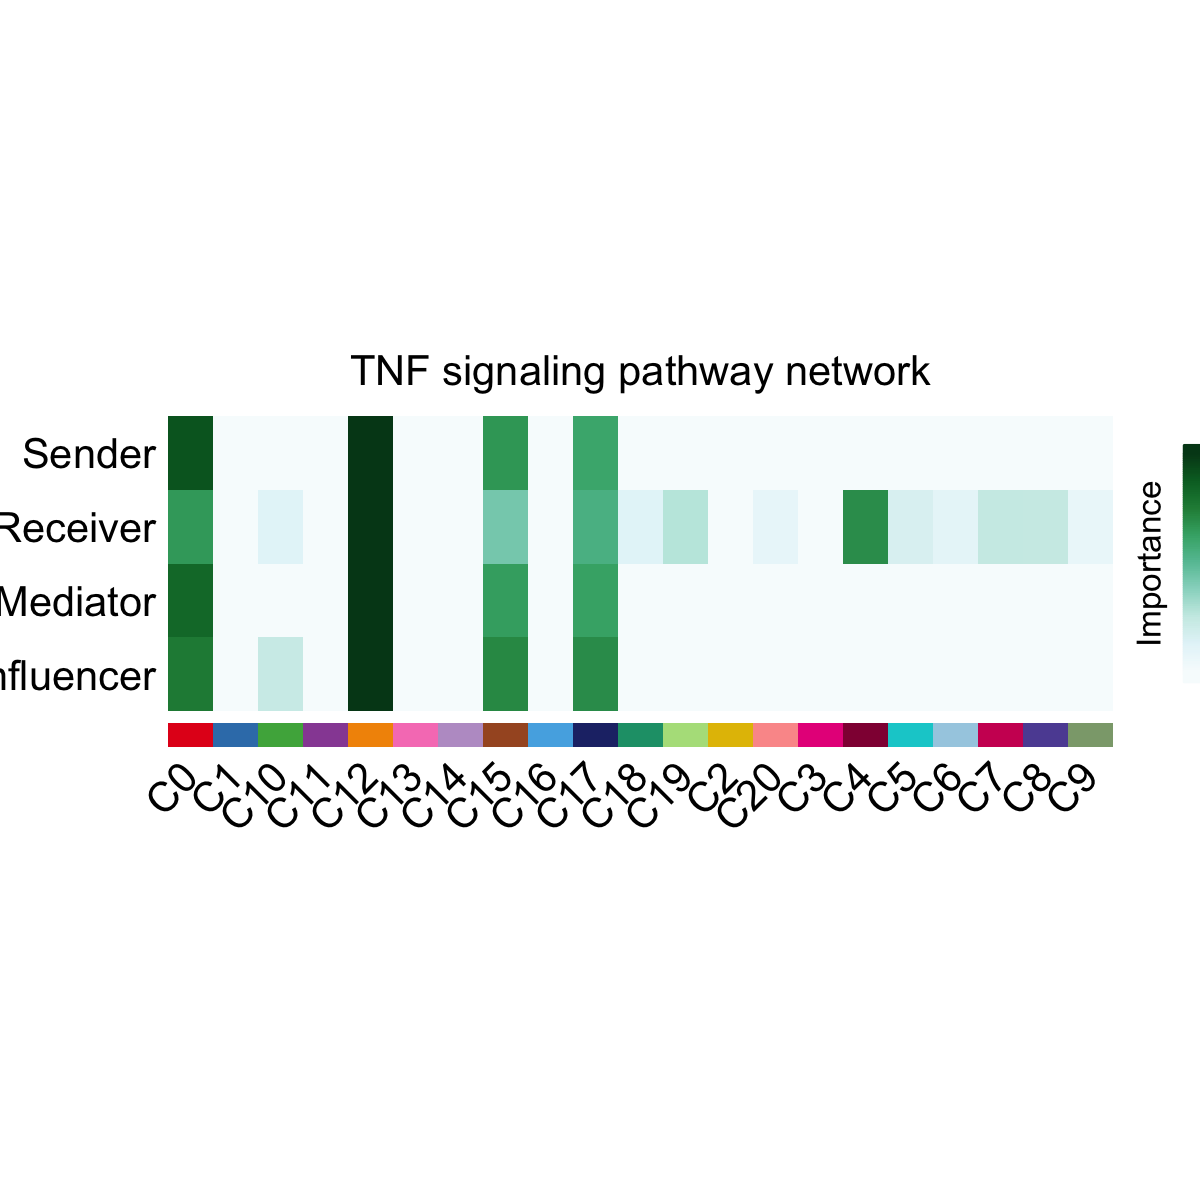

In [147]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)
netAnalysis_signalingRole_network(
  cellchat,
  signaling = c("TNF"),
  width = 8,
  height = 2.5,
  font.size = 10
)

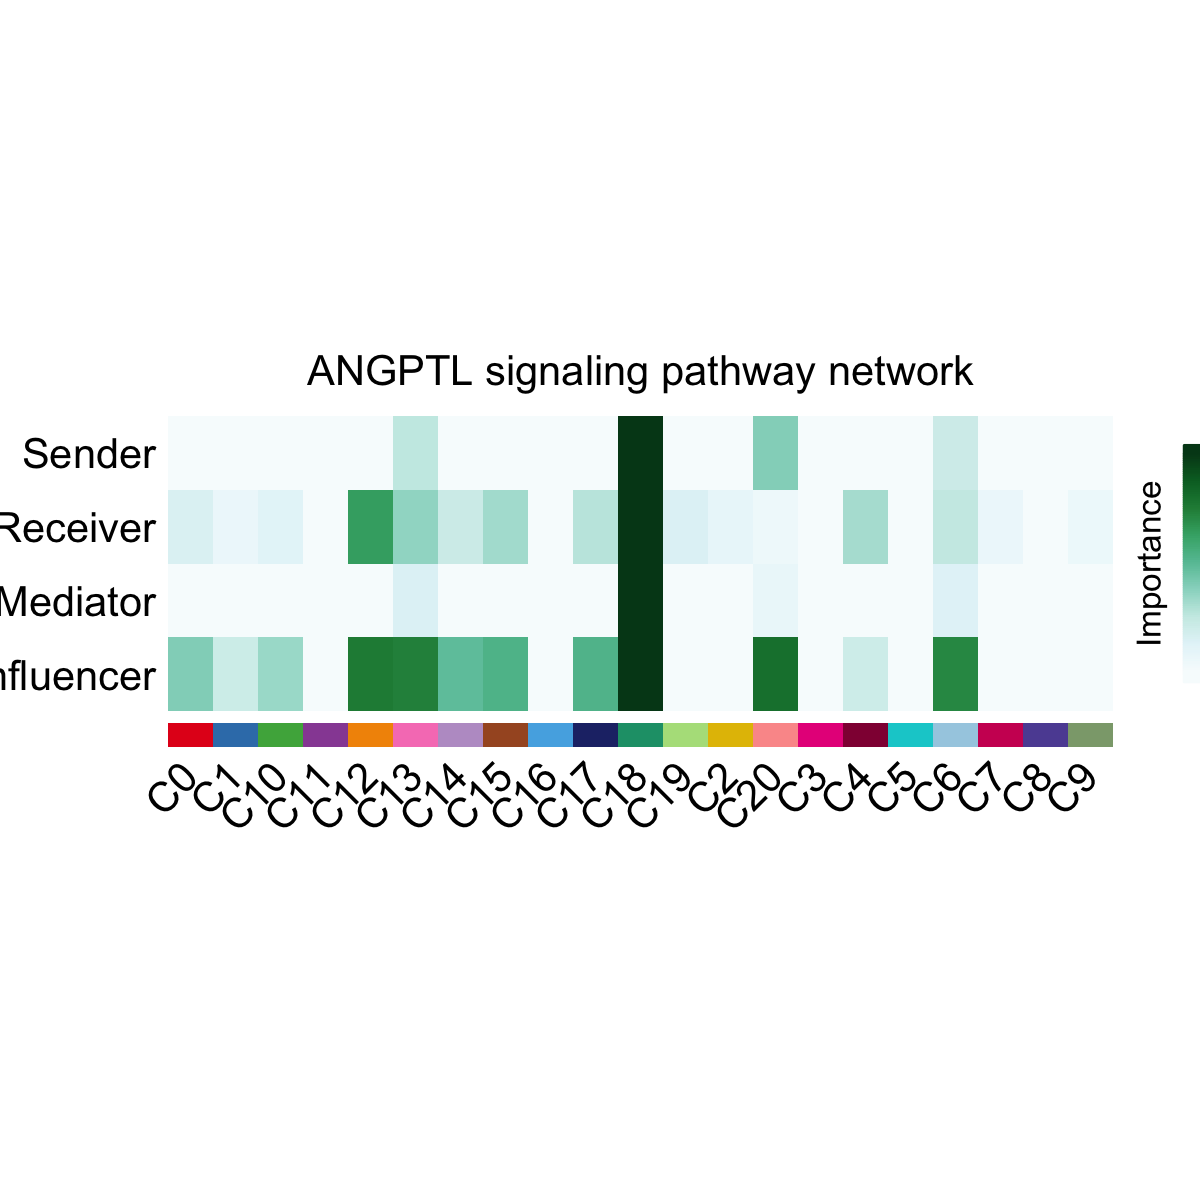

In [148]:

options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)
netAnalysis_signalingRole_network(
  cellchat,
  signaling = c("ANGPTL"),
  width = 8,
  height = 2.5,
  font.size = 10
)

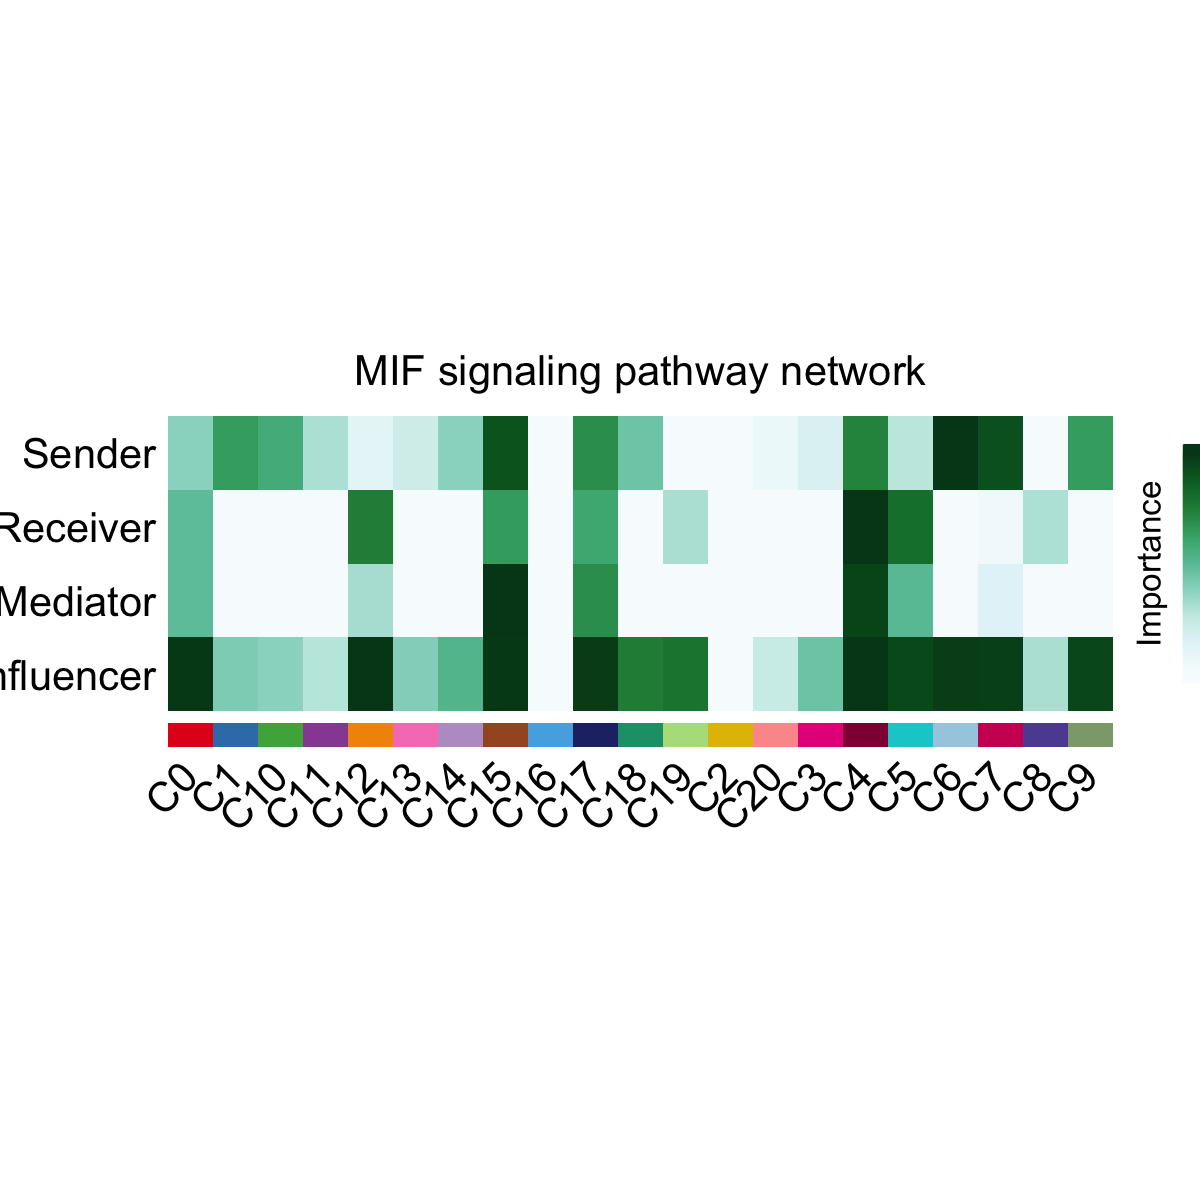

In [164]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)
netAnalysis_signalingRole_network(
  cellchat,
  signaling = c("MIF"),
  width = 8,
  height = 2.5,
  font.size = 10
)

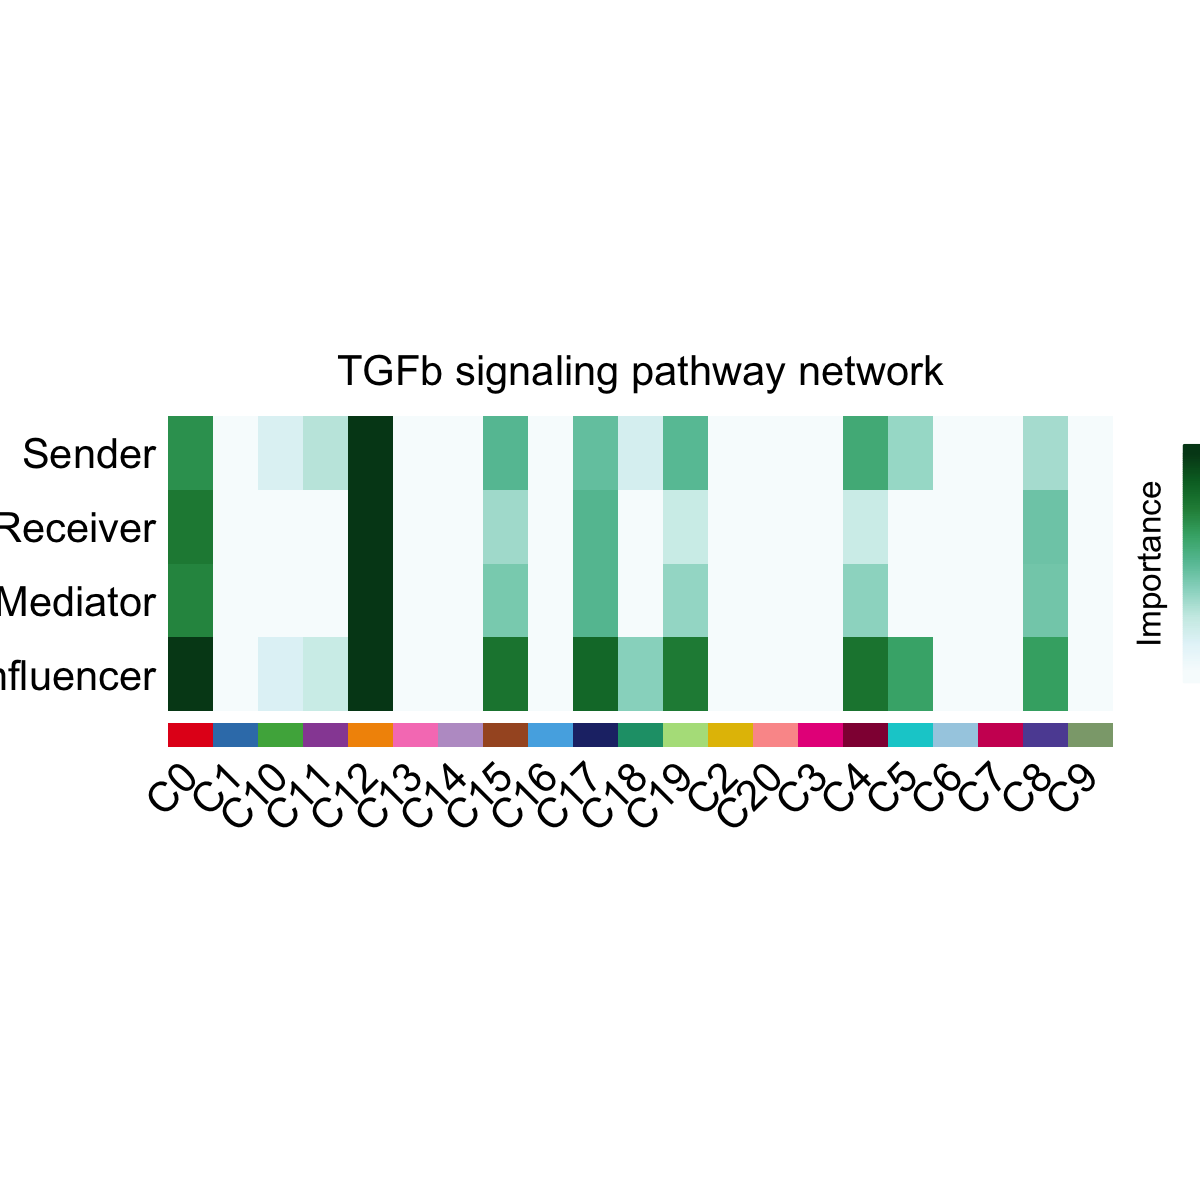

In [165]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)
netAnalysis_signalingRole_network(
  cellchat,
  signaling = c("TGFb"),
  width = 8,
  height = 2.5,
  font.size = 10
)

### Identify signals contributing the most to outgoing or incoming signaling of certain cell groups

In [149]:
ht1 <- netAnalysis_signalingRole_heatmap(cellchat, pattern = "outgoing")
ht2 <- netAnalysis_signalingRole_heatmap(cellchat, pattern = "incoming")

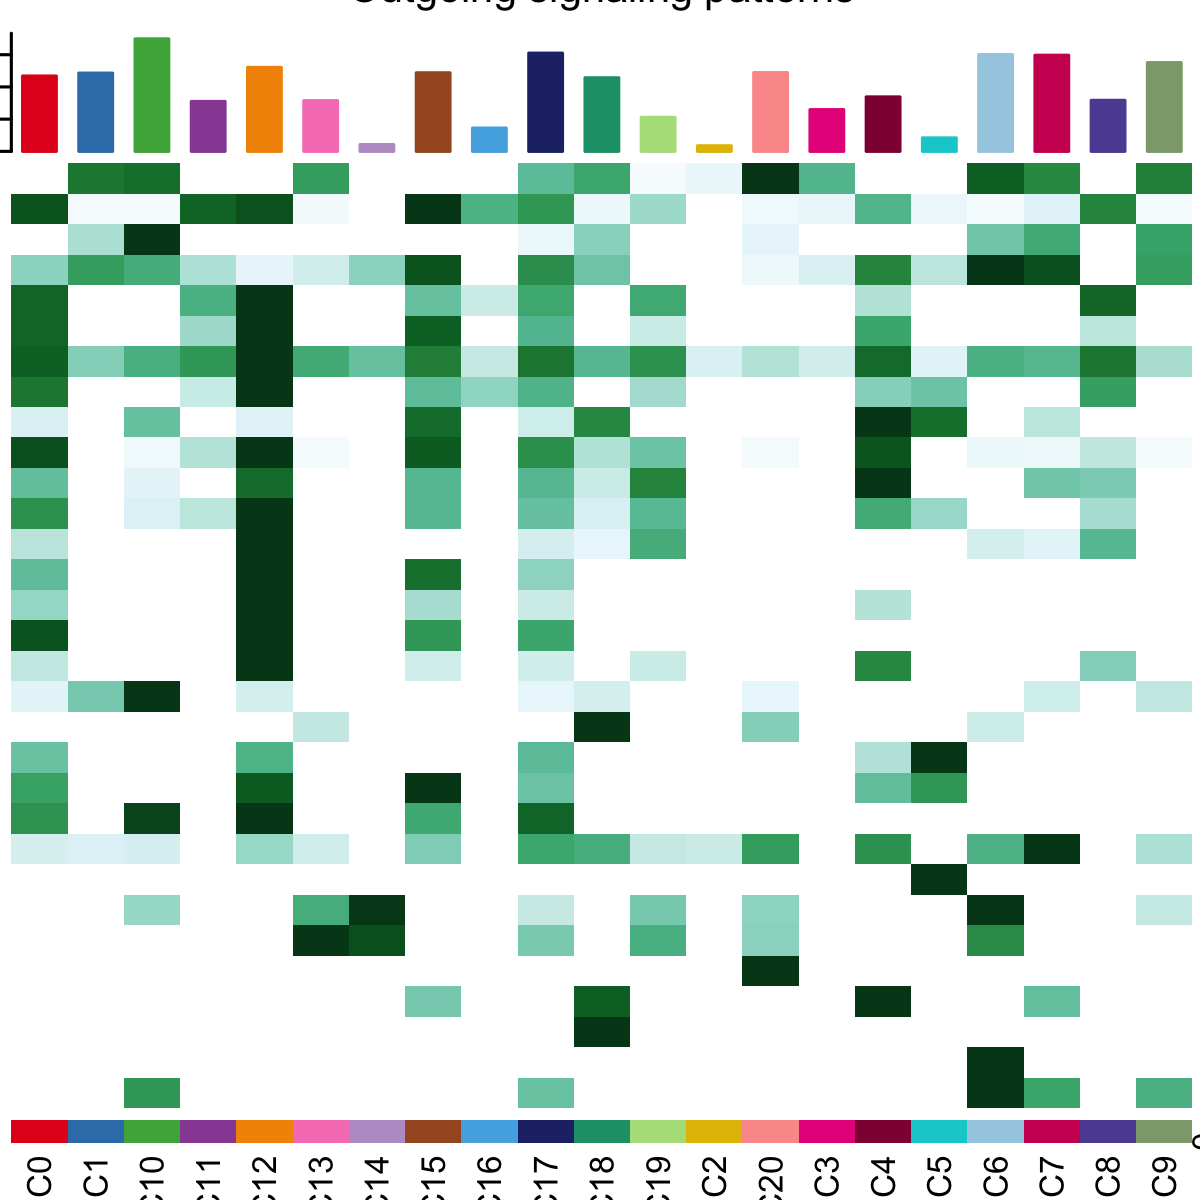

In [150]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)
ht1

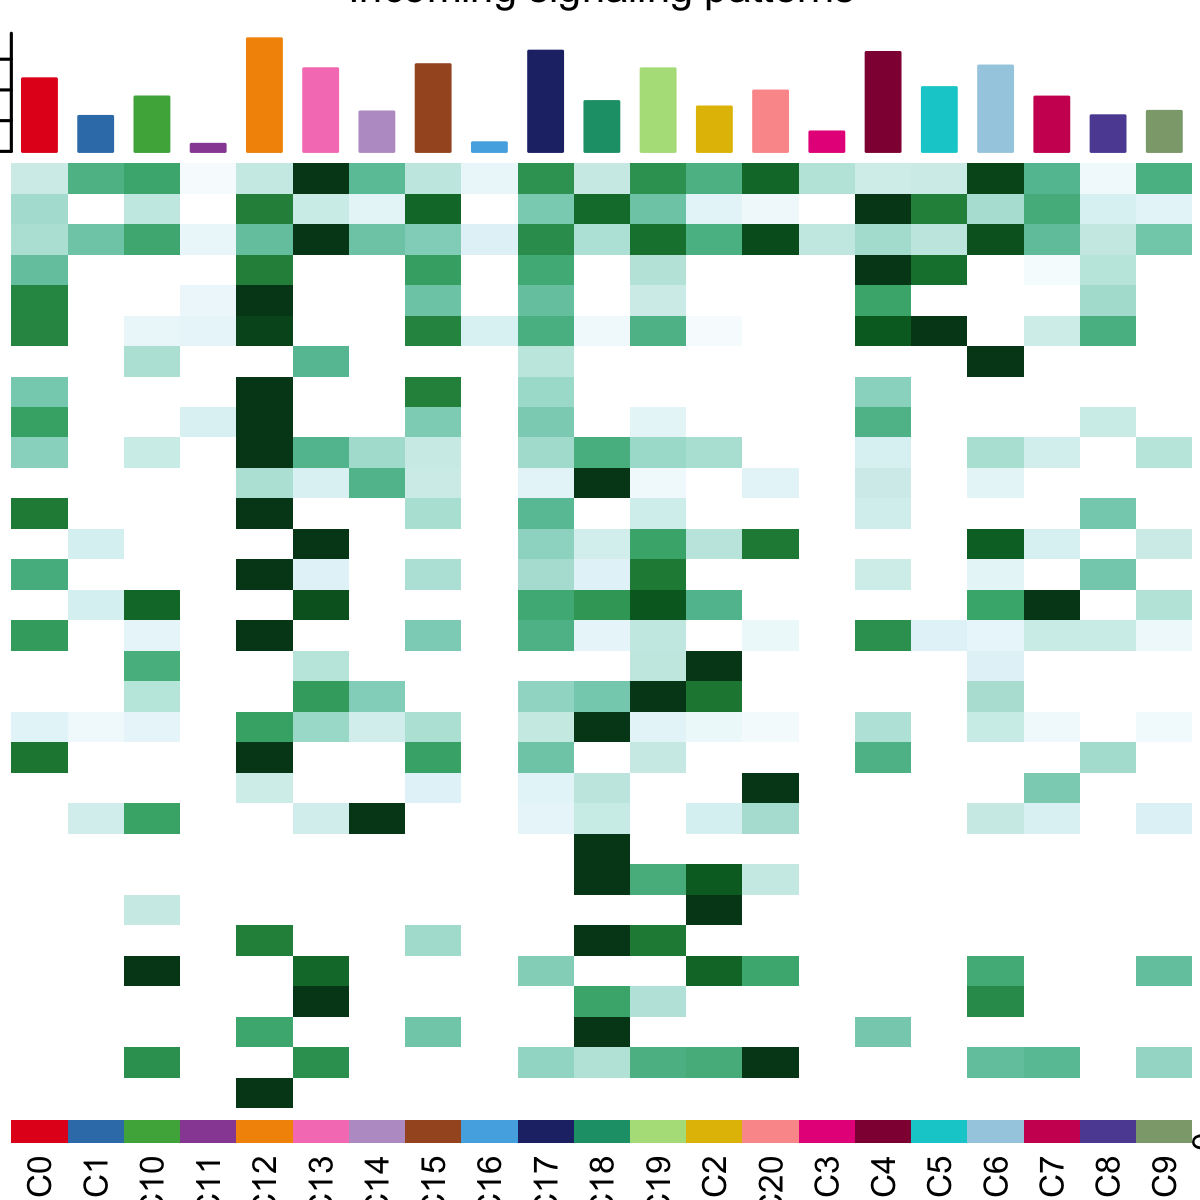

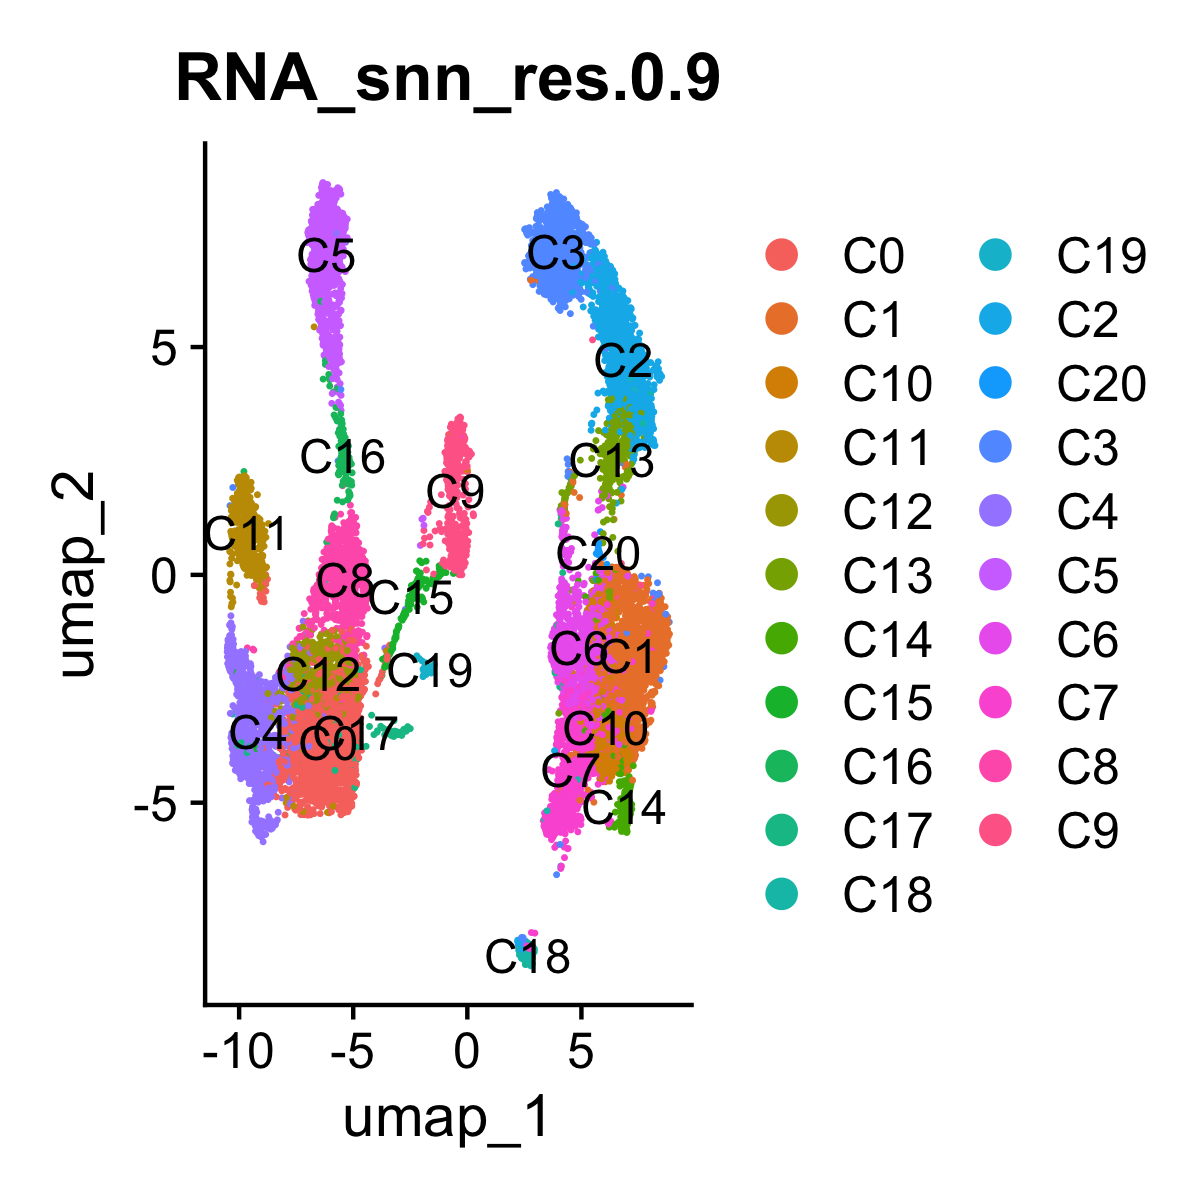

In [163]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)
umap <- DimPlot(seurat_object, reduction = "umap", group.by="RNA_snn_res.0.9", label = TRUE)

ht2
umap

### Identify global communication patterns to explore how multiple cell types and signaling pathways coordinate together

In [88]:
library(NMF)
library(ggalluvial)

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 2/2

  To enable shared memory capabilities, try: install.extras('
NMF
')


Attaching package: 'NMF'


The following objects are masked from 'package:igraph':

    algorithm, compare




### Identify and visualize outgoing communication pattern of secreting cells

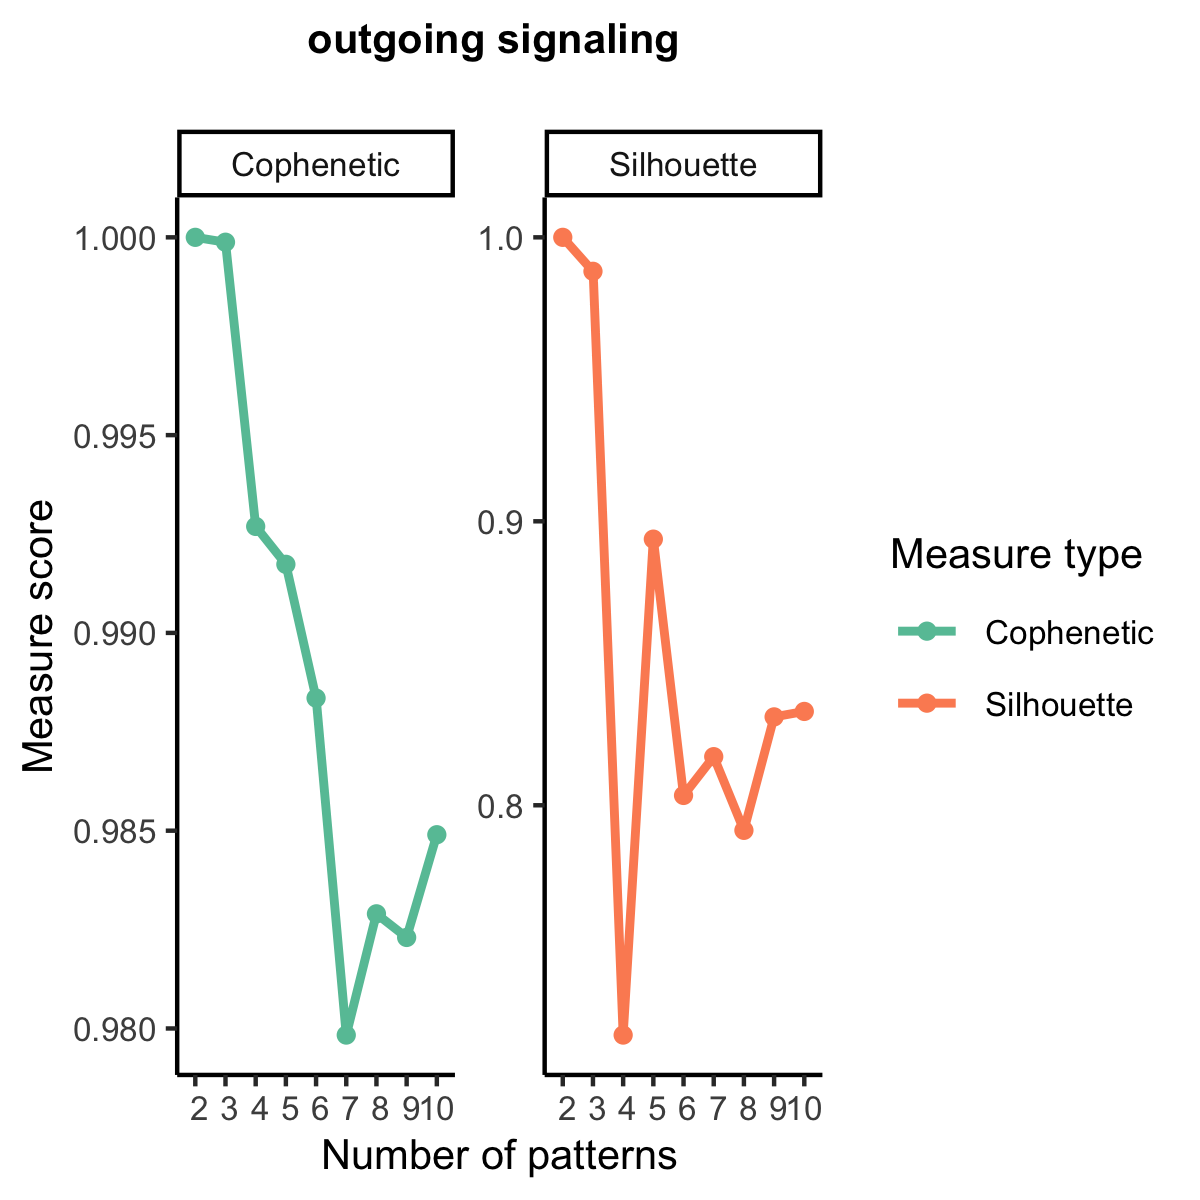

In [151]:
selectK(cellchat, pattern = "outgoing")

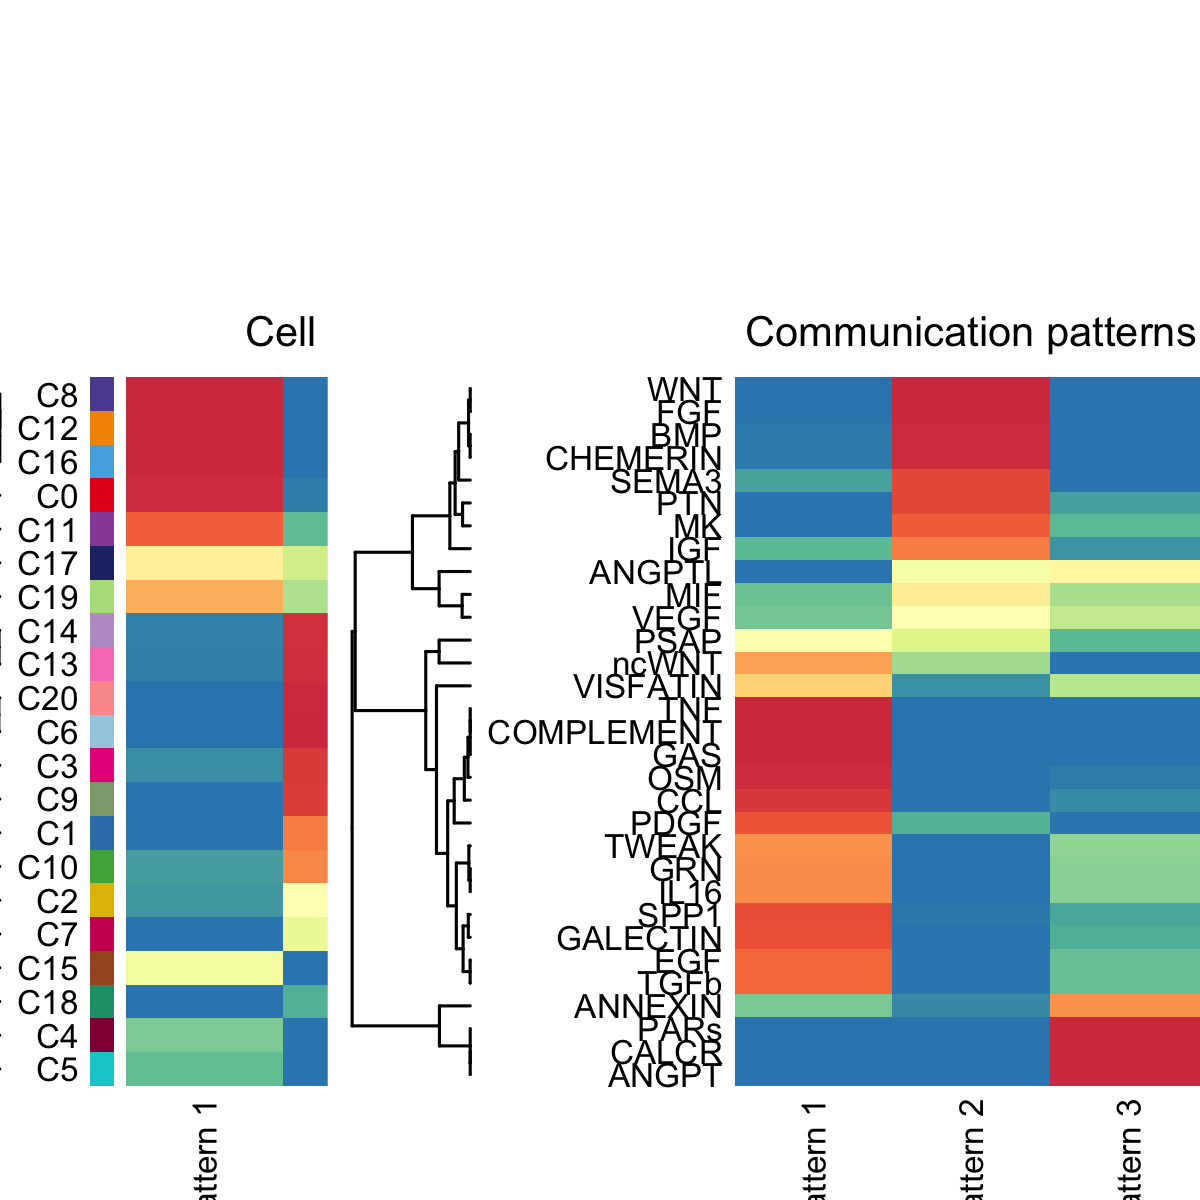

In [166]:
nPatterns <- 3
cellchat <- identifyCommunicationPatterns(
  cellchat,
  pattern = "outgoing",
  k = nPatterns
)

Please make sure you have load `library(ggalluvial)` when running this function



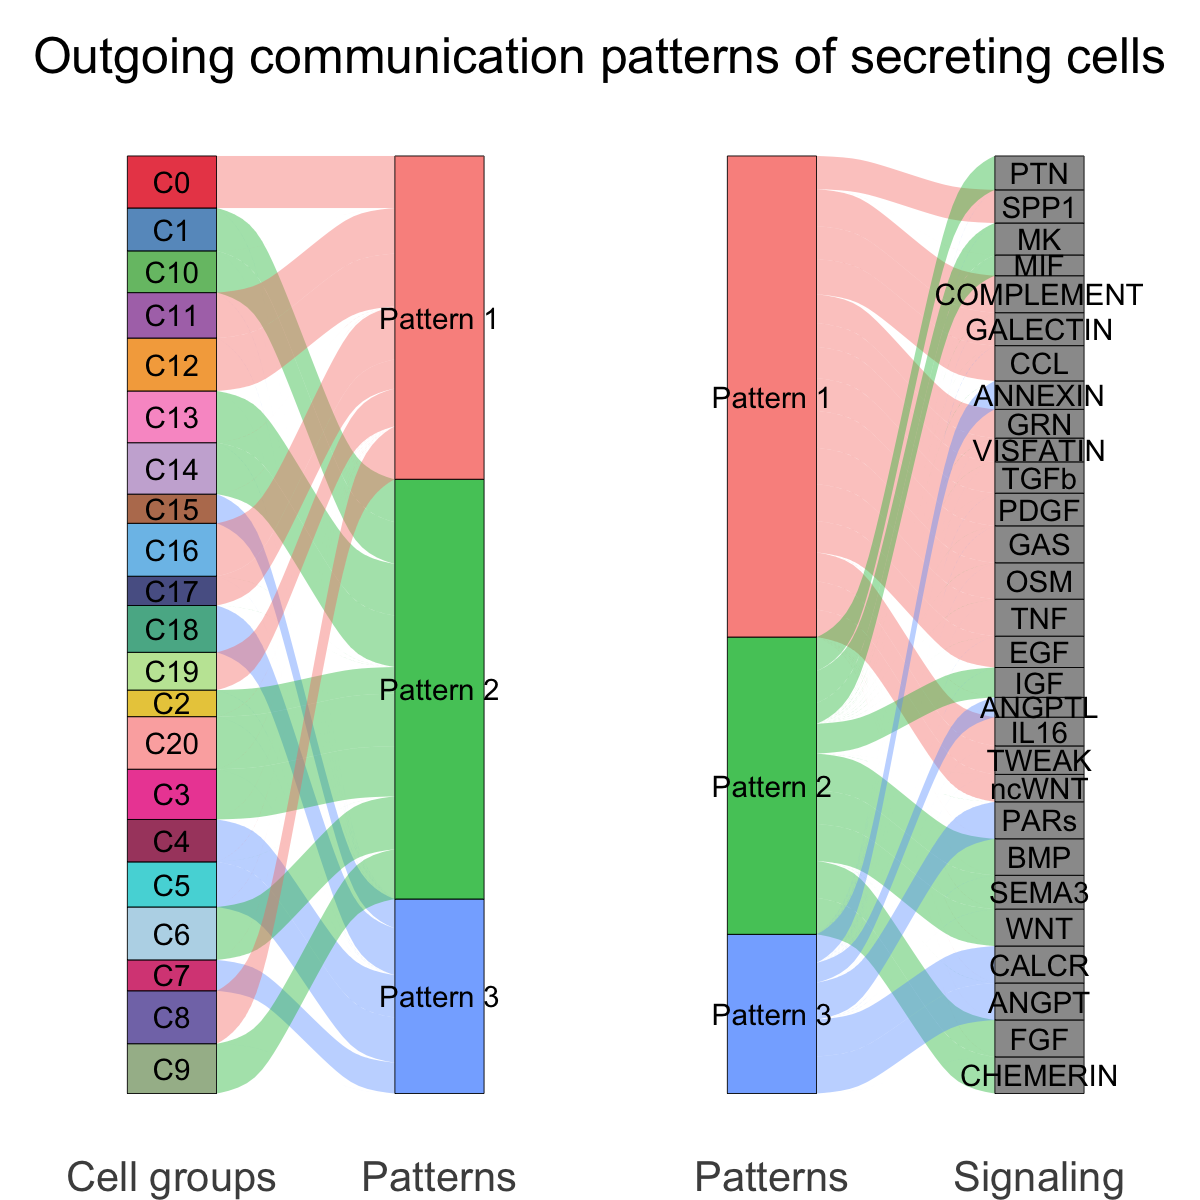

In [167]:
netAnalysis_river(cellchat, pattern = "outgoing")

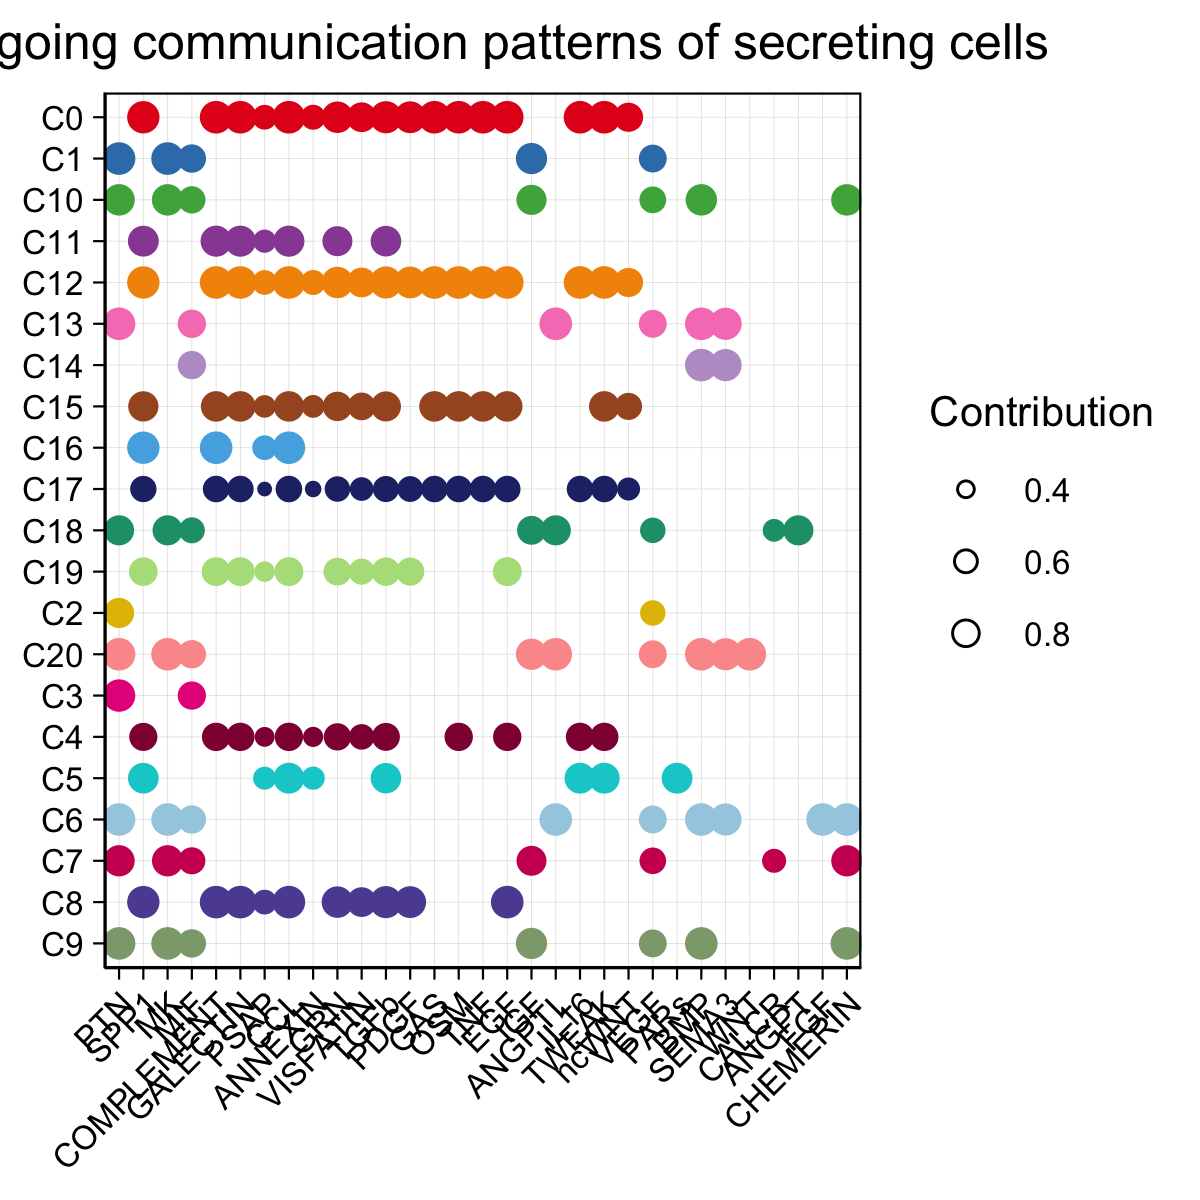

In [154]:
netAnalysis_dot(cellchat, pattern = "outgoing")

### Identify and visualize incoming communication pattern of target cells

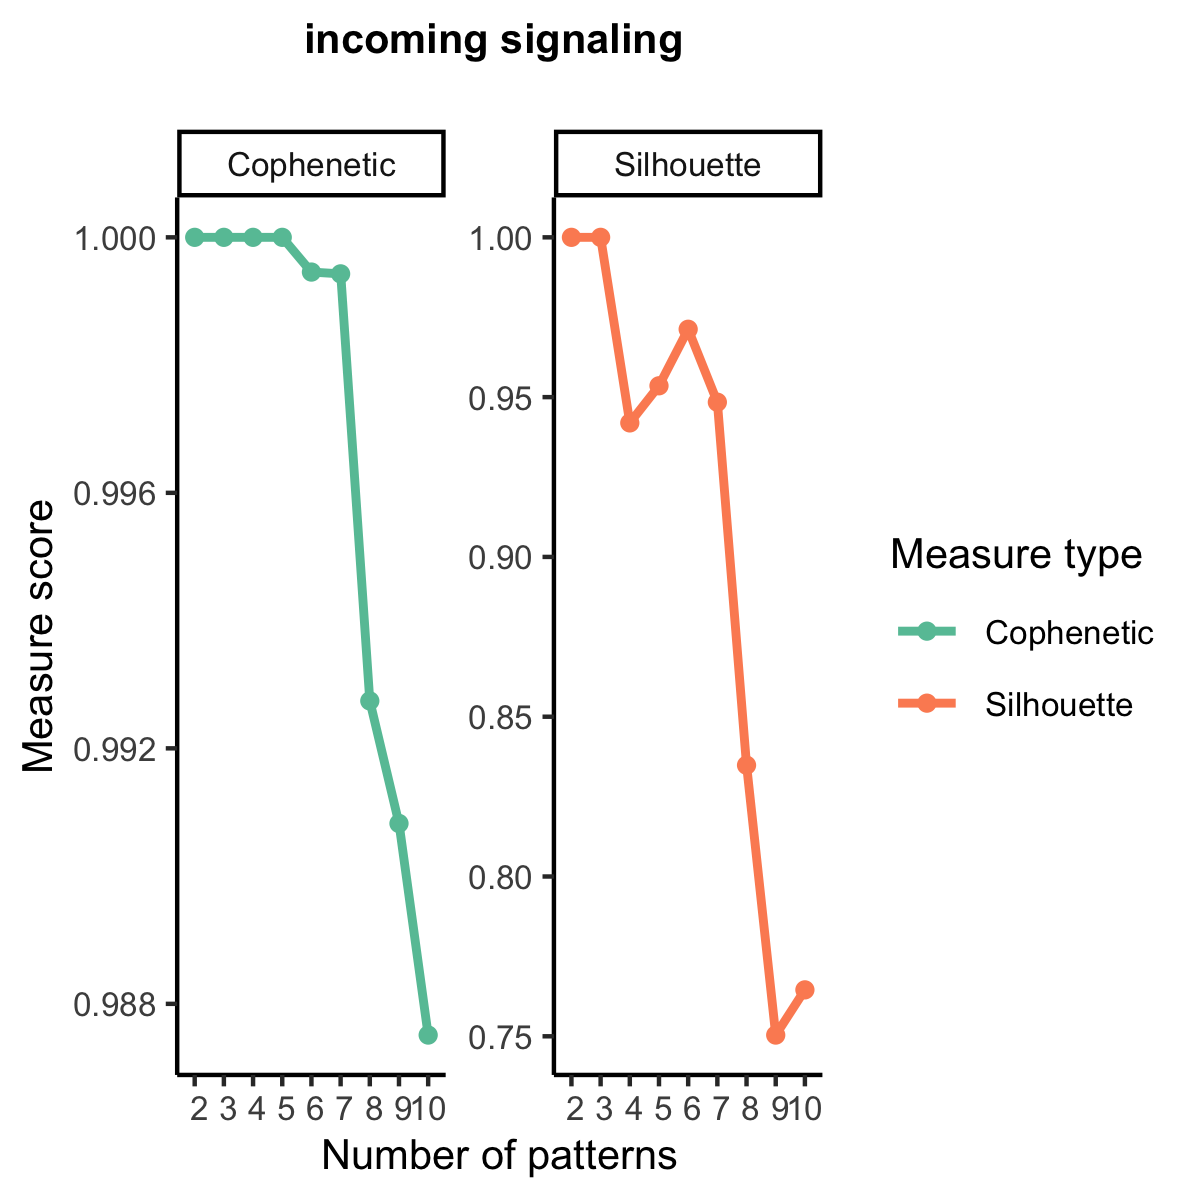

In [155]:
selectK(cellchat, pattern = "incoming")

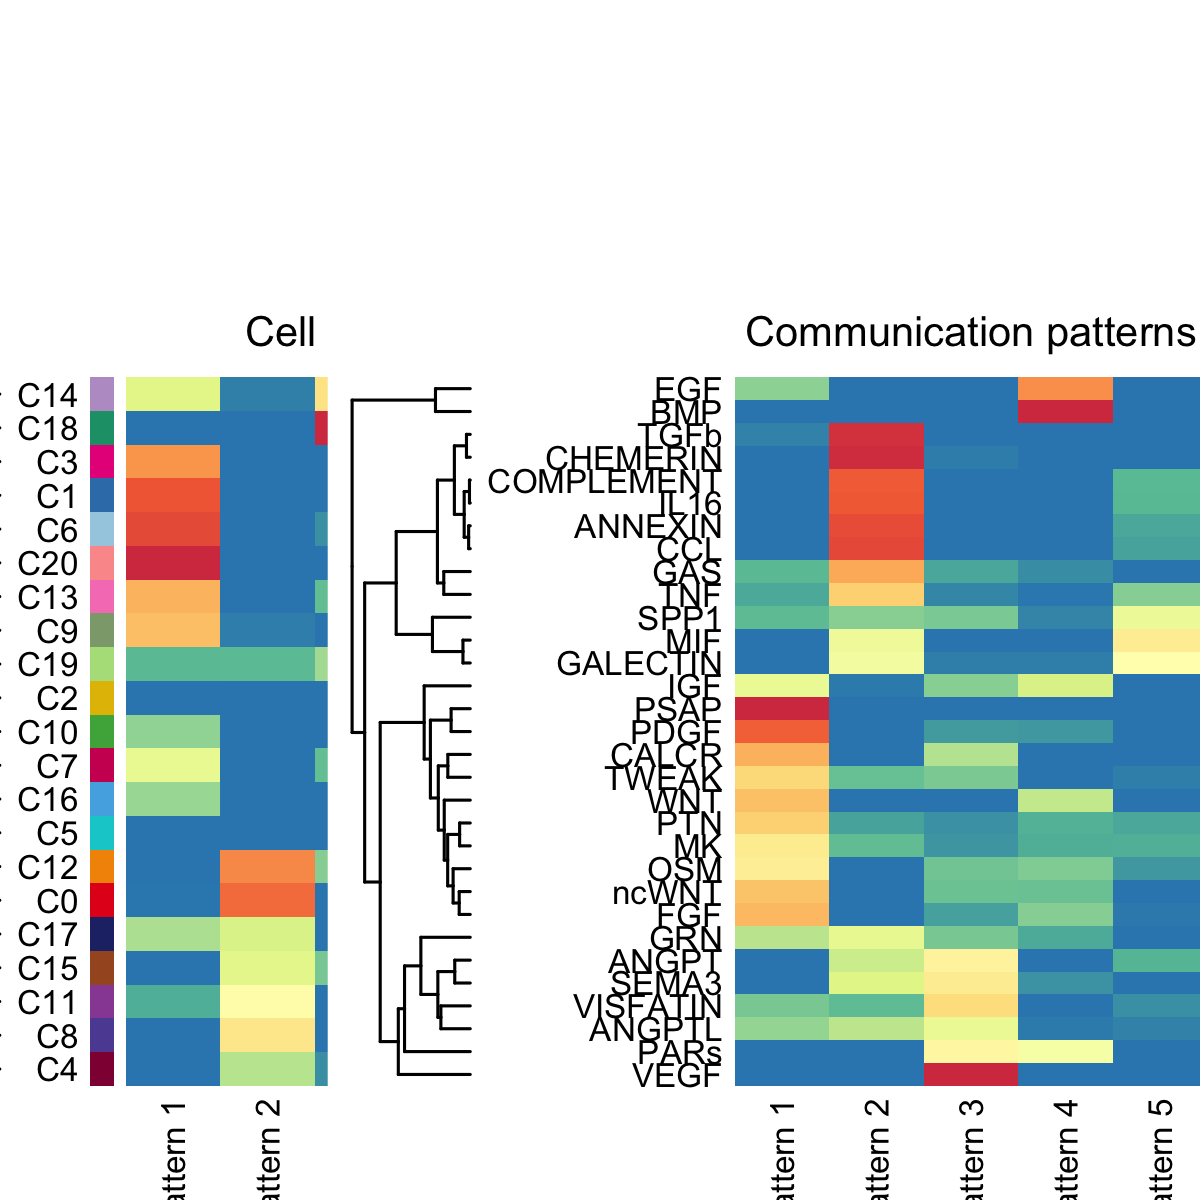

In [168]:
nPatterns <- 5
cellchat <- identifyCommunicationPatterns(
  cellchat,
  pattern = "incoming",
  k = nPatterns
)

Please make sure you have load `library(ggalluvial)` when running this function



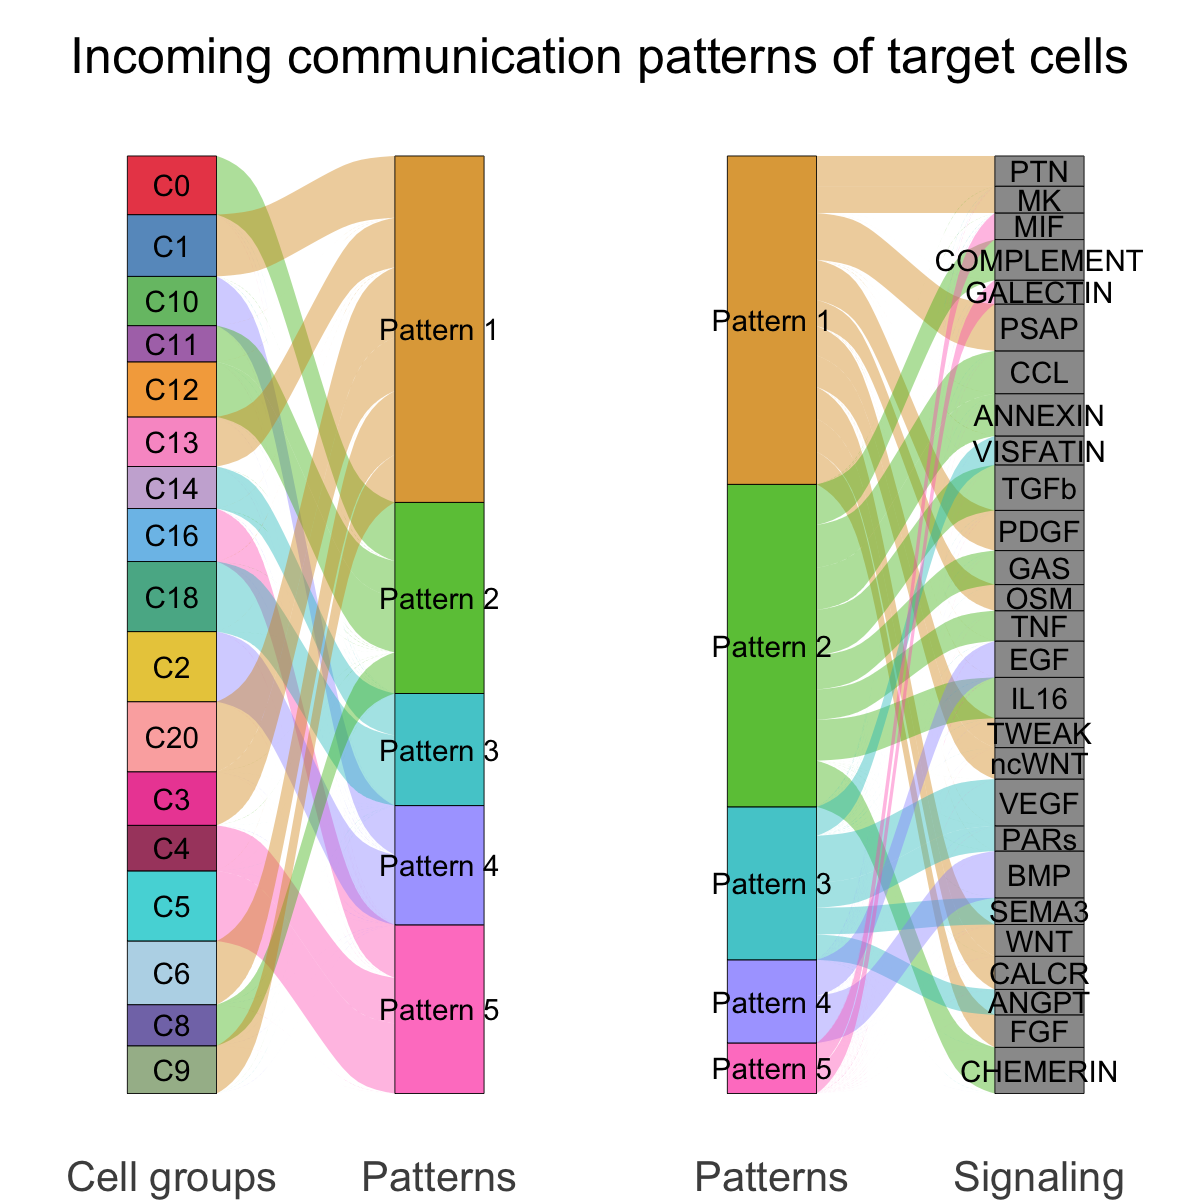

In [169]:
netAnalysis_river(cellchat, pattern = "incoming")

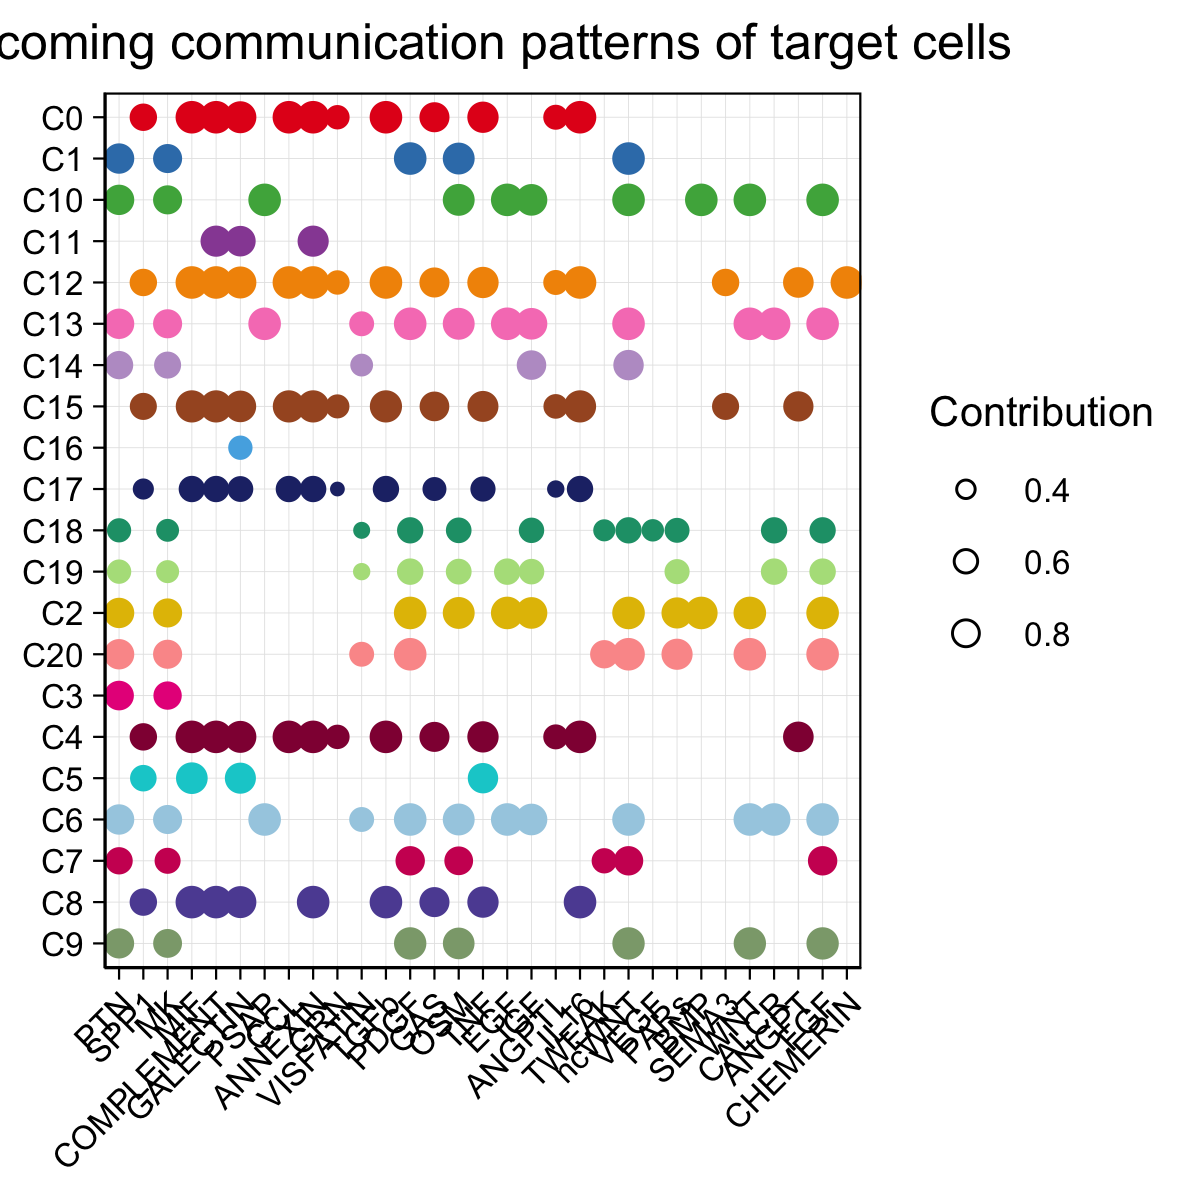

In [158]:
netAnalysis_dot(cellchat, pattern = "incoming")

### Save `CellChat` object

In [159]:
saveRDS(file = "out/cellchat_p2.rds", cellchat)

In [112]:
communications_TGFb <- subsetCommunication(cellchat, signaling = "TGFb")

In [160]:
# Extract unique ligand-receptor pairs
ligand_receptor_TGFb <- unique(communications_TGFb[, c("ligand", "receptor")])

print(ligand_receptor_TGFb)


  ligand  receptor
1  TGFB1 TGFbR1_R2


Comparing communications on a single object 


Do heatmap based on a single object 




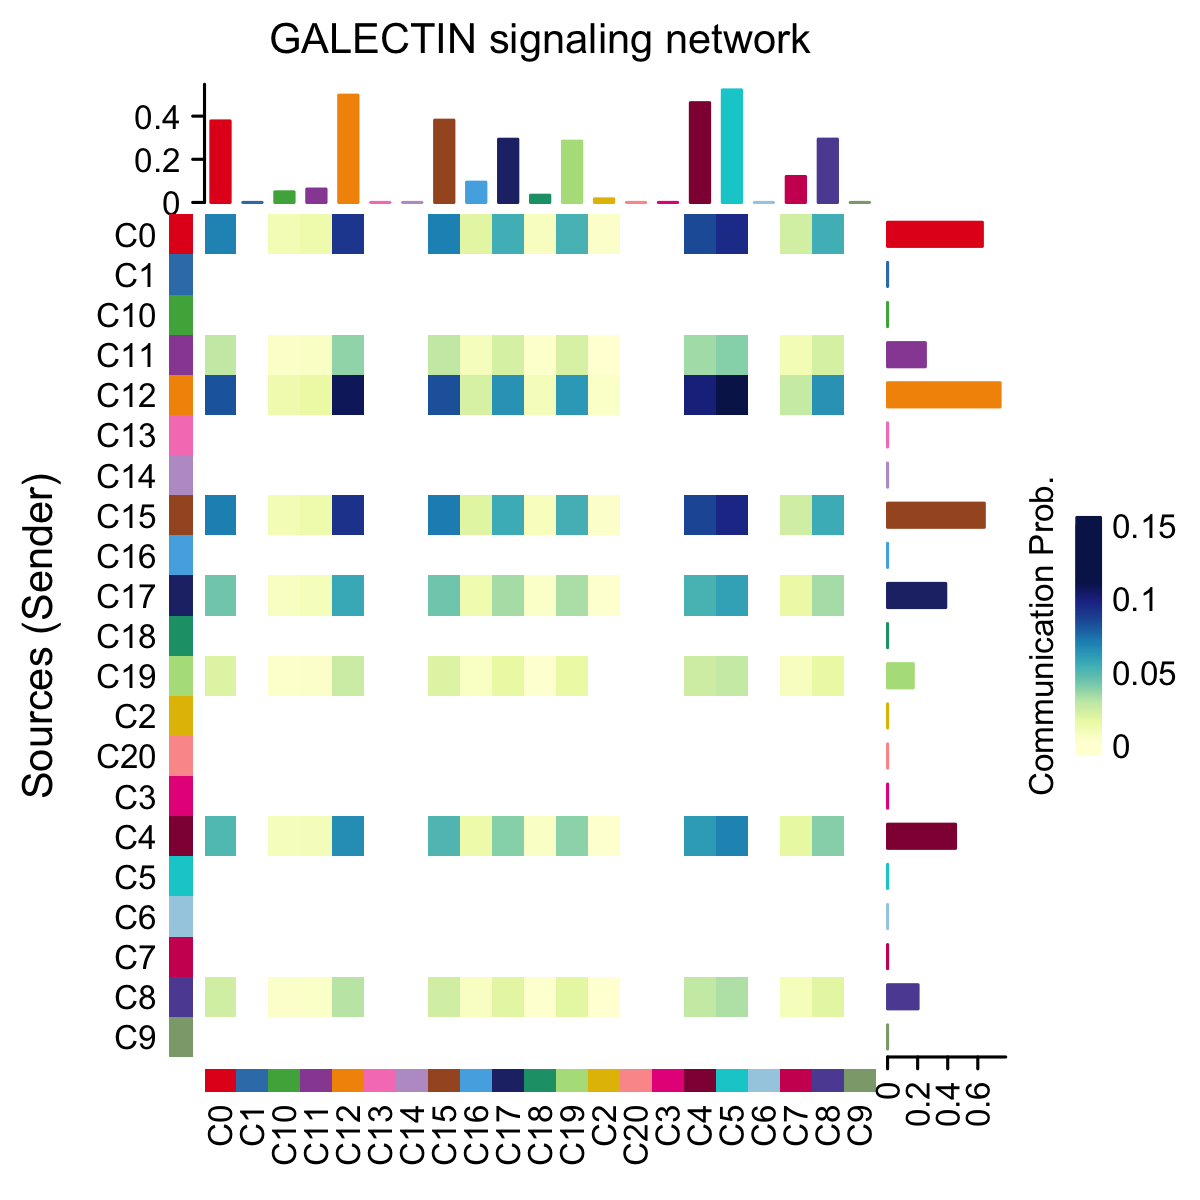

In [175]:
# Visualize the network
library(ggplot2)

# Create a network plot using CellChat's built-in function
netVisual_bubble(cellchat, signaling = "GALECTIN", sources.use = NULL, targets.use = NULL)

# Alternatively, visualize using a different layout
netVisual_heatmap(cellchat, signaling = "GALECTIN", color.heatmap = "YlGnBu")


Do heatmap based on a single object 




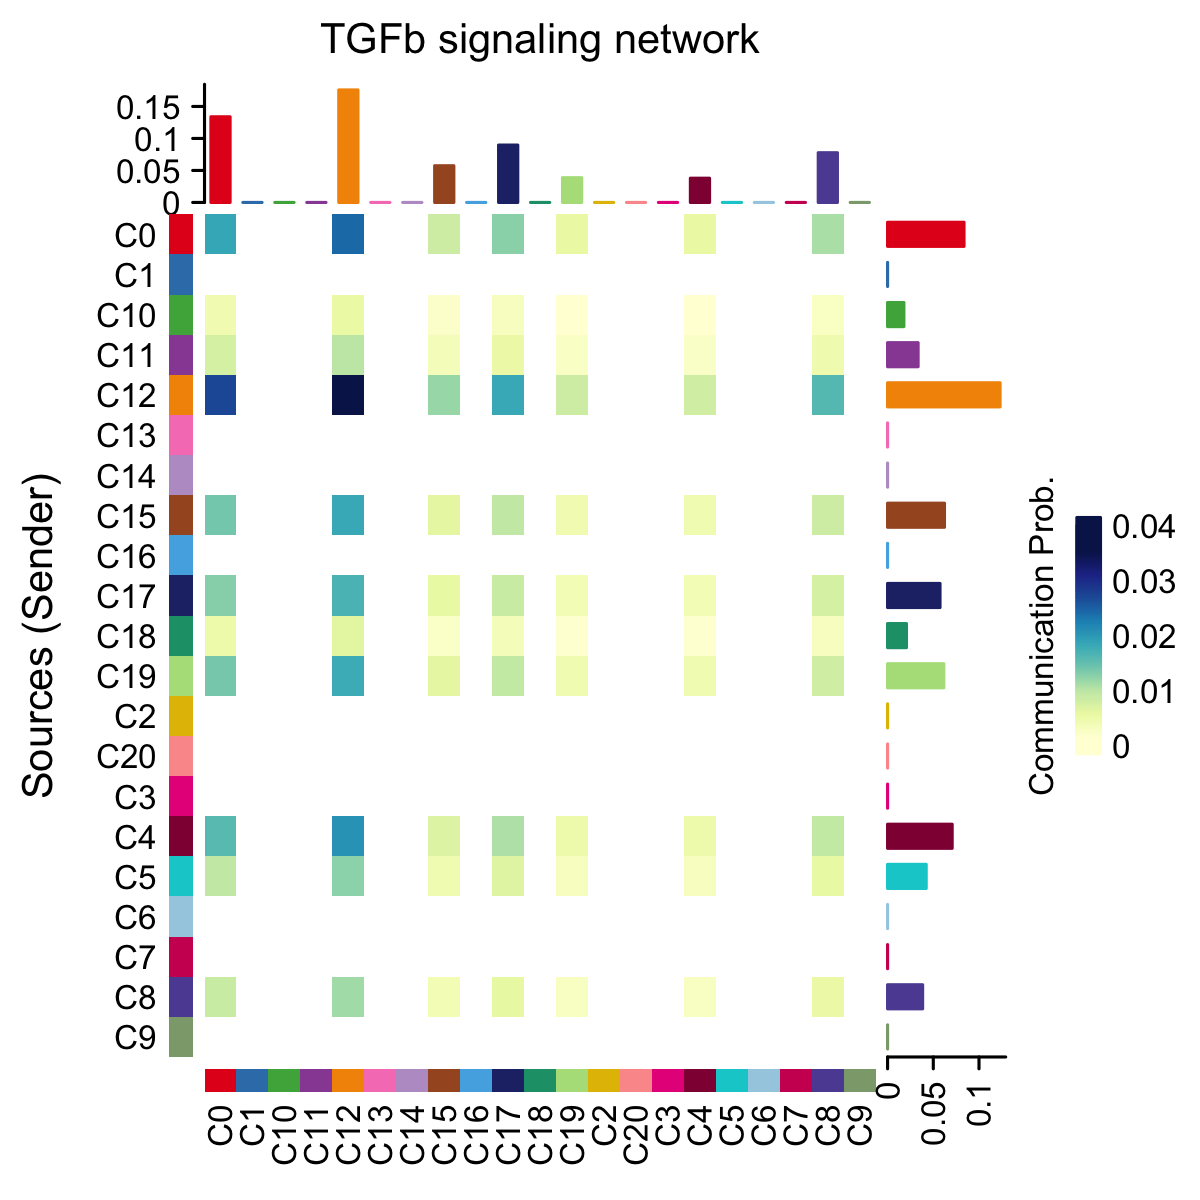

In [171]:

# Alternatively, visualize using a different layout
netVisual_heatmap(cellchat, signaling = "TGFb", color.heatmap = "YlGnBu")


### Manifold and classification learning analysis of signaling networks

### Identify signaling groups based on their functional similarity

In [108]:

# Check if 'umap' is available
py_module_available("umap")


[1] FALSE

In [101]:
cellchat <- computeNetSimilarity(cellchat, type = "functional")
cellchat <- netEmbedding(cellchat, type = "functional")
cellchat <- netClustering(cellchat, type = "functional", k = 4)

Manifold learning of the signaling networks for a single dataset 


ERROR: Error in runUMAP(Similarity, min_dist = min_dist, n_neighbors = n_neighbors, : Cannot find UMAP, please install through pip (e.g. pip install umap-learn or reticulate::py_install(packages = 'umap-learn')).


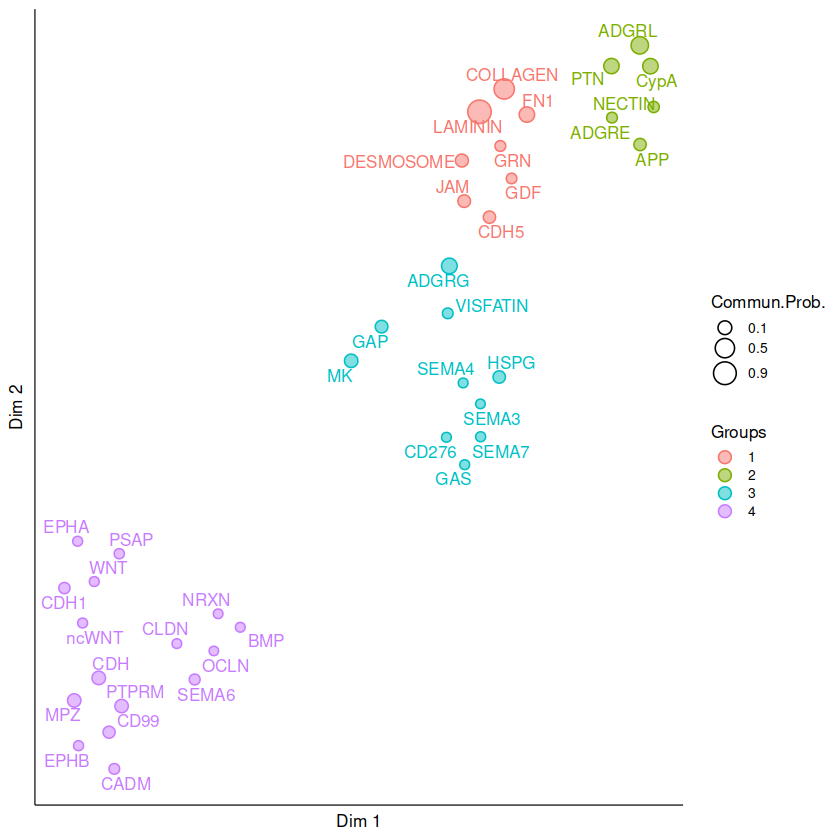

In [63]:
netVisual_embedding(cellchat, type = "functional", label.size = 3.5)

### Identify signaling groups based on structure similarity

In [110]:
cellchat <- computeNetSimilarity(cellchat, type = "structural")
cellchat <- netEmbedding(cellchat, type = "structural")
cellchat <- netClustering(cellchat, type = "structural", k = 4)

Manifold learning of the signaling networks for a single dataset 


ERROR: Error in runUMAP(Similarity, min_dist = min_dist, n_neighbors = n_neighbors, : Cannot find UMAP, please install through pip (e.g. pip install umap-learn or reticulate::py_install(packages = 'umap-learn')).


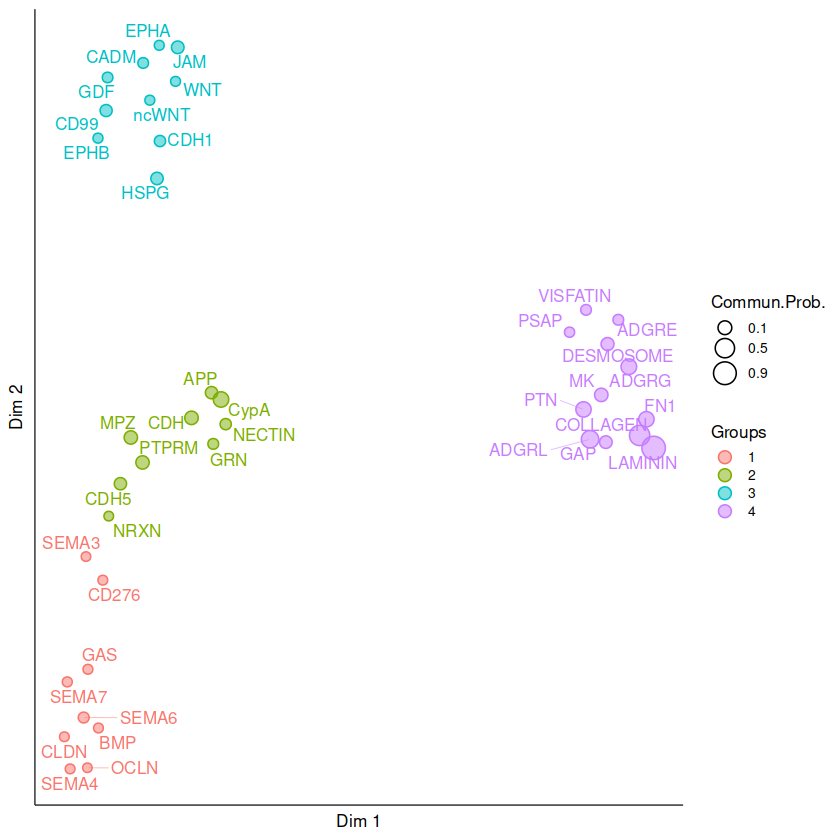

In [66]:
netVisual_embedding(cellchat, type = "structural", label.size = 3.5)

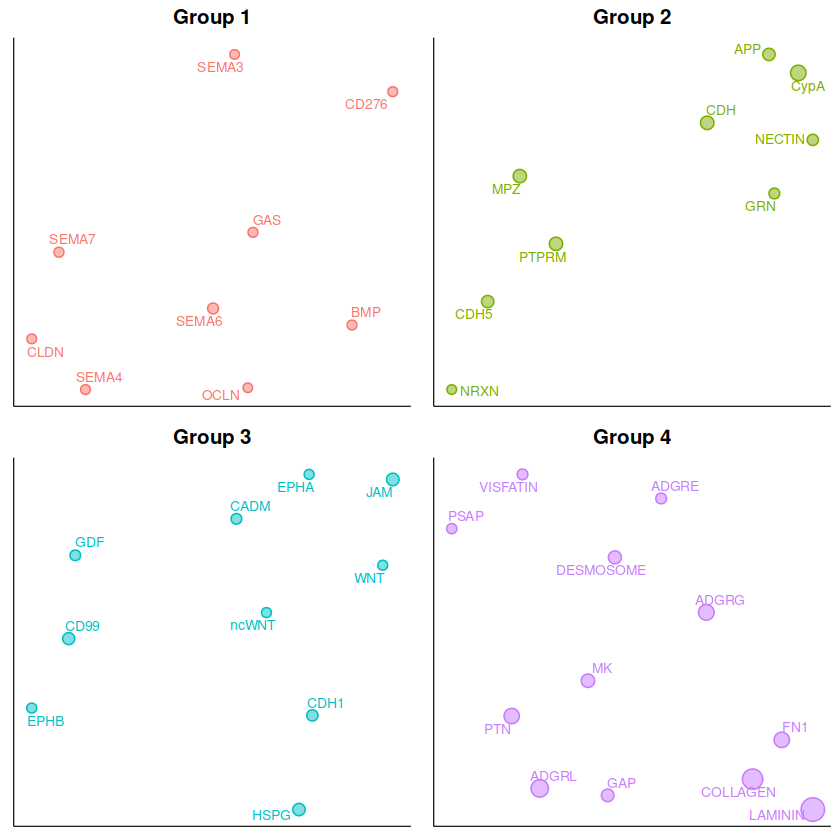

In [67]:
netVisual_embeddingZoomIn(cellchat, type = "structural", nCol = 2)

### Save the CellChat object

In [68]:
saveRDS(cellchat, file = "out/cellchat/cellchat.rds")